<div style="color:#3c4d5a; border-top: 7px solid #42A5F5; border-bottom: 7px solid #42A5F5; padding: 5px; text-align: center; text-transform: uppercase"><h1>Boletín 2 - Aprendizaje por transferencia para clasificación de imágenes médicas</h1> </div>

Integrantes:
* Berenice Arguero
* Marcela Mosquera
* Edison Naranjo

# Modelo de Deep Learning para detectar tumores de cerebro usando ResNet50

## Importación  de las librerías requeridas

In [ ]:
# Instalación de Tensorflow
# =========================

! pip install tensorflow -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 819.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 625.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 23.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages


## Carga de Datos

Se cargará los datos desde Google Drive

In [ ]:
# Cargar datos desde Google Drive
# ===============================

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Funciones para obtener los dataframes de entrenamiento y prueba con la ruta de la imagen y la clase a la que pertenece

In [ ]:
# Función llamada test_df que toma un argumento ts_path, el cual es la ruta
# al directorio raíz que contiene las subcarpetas de las diferentes clases
# de imágenes.

def test_df(ts_path):

  # Se inicializan dos listas vacías: classes para almacenar las etiquetas de
  # las clases y class_paths para almacenar las rutas completas de las imágenes.

  classes = []
  class_paths = []

  # Variable para obtener una lista de los nombres de las subcarpetas en el
  # directorio ts_path. Cada subcarpeta se asume que representa una clase diferente.

  files = os.listdir(ts_path)

  # Iteración a través de las Subcarpetas y Archivos

  for file in files:

    # Ruta completa a la subcarpeta.

    label_dir = os.path.join(ts_path, file)

    # Lista de todos los archivos (imágenes) en la subcarpeta.

    label = os.listdir(label_dir)

    # Se itera sobre cada archivo de imagen en label.

    for image in label:

      # Ruta completa a la imagen.

      image_path = os.path.join(label_dir, image)

      # Añade la ruta de la imagen a la lista class_paths.

      class_paths.append(image_path)

      # Añade la etiqueta de la clase (nombre de la subcarpeta) a la lista classes.

      classes.append(file)

  # Se crea una Serie de Pandas con las etiquetas de clase, nombrada 'Class'.

  image_classes = pd.Series(classes, name='Class')

  # Se crea una Serie de Pandas con las rutas de las imágenes, nombrada 'Class Path'.

  image_paths = pd.Series(class_paths, name='Class Path')

  # Combina las dos Series en un DataFrame de Pandas a lo largo del eje de columnas (axis=1).

  ts_df = pd.concat([image_paths, image_classes], axis=1)

  # Se devuelve el DataFrame resultante.

  return ts_df

La explicación es la misma para la función **train_df**

In [ ]:

def train_df(tr_path):
  classes = []
  class_paths = []
  files = os.listdir(tr_path)

  for file in files:
    label_dir = os.path.join(tr_path, file)
    label = os.listdir(label_dir)
    for image in label:
      image_path = os.path.join(label_dir, image)
      class_paths.append(image_path)
      classes.append(file)

  image_classes = pd.Series(classes, name='Class')
  image_paths = pd.Series(class_paths, name='Class Path')
  tr_df = pd.concat([image_paths, image_classes], axis=1)
  return tr_df

In [ ]:
# La variable tr_df se obtiene de la función train_df utilizando la ruta
# /content/drive/MyDrive/Tumor_Brain/Training

tr_df = train_df(tr_path="/content/drive/MyDrive/Tumor_Brain/Training")

In [ ]:
print(f"El dataframe de entranemiento tiene {tr_df.shape[0]} filas y {tr_df.shape[1]} columnas")

El dataframe de entranemiento tiene 5712 filas y 2 columnas


In [ ]:
# Cinco primeras filas del dataframe tr_df

tr_df.head()

Class Path      Class
0  /content/drive/MyDrive/Tumor_Brain/Training/pi...  pituitary
1  /content/drive/MyDrive/Tumor_Brain/Training/pi...  pituitary
2  /content/drive/MyDrive/Tumor_Brain/Training/pi...  pituitary
3  /content/drive/MyDrive/Tumor_Brain/Training/pi...  pituitary
4  /content/drive/MyDrive/Tumor_Brain/Training/pi...  pituitary

In [ ]:
# La variable ts_df se obtiene de la función train_df utilizando la ruta
# /content/drive/MyDrive/Tumor_Brain/Testing

ts_df = test_df('/content/drive/MyDrive/Tumor_Brain/Testing')

In [ ]:
print(f"El dataframe de entranemiento tiene {ts_df.shape[0]} filas y {ts_df.shape[1]} columnas")

El dataframe de entranemiento tiene 1311 filas y 2 columnas


In [ ]:
ts_df.head()

Class Path      Class
0  /content/drive/MyDrive/Tumor_Brain/Testing/pit...  pituitary
1  /content/drive/MyDrive/Tumor_Brain/Testing/pit...  pituitary
2  /content/drive/MyDrive/Tumor_Brain/Testing/pit...  pituitary
3  /content/drive/MyDrive/Tumor_Brain/Testing/pit...  pituitary
4  /content/drive/MyDrive/Tumor_Brain/Testing/pit...  pituitary

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

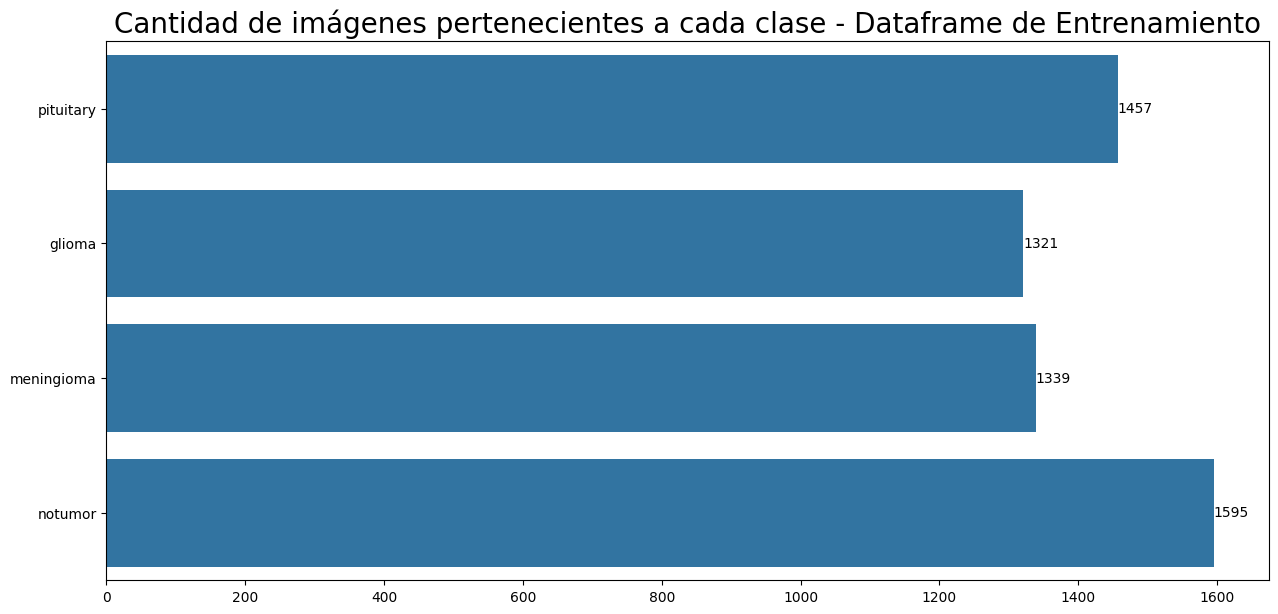

In [ ]:
# Cantidad de imágenes pertenecientes a cada clase - DataFrame de Entrenamiento
# =============================================================================

plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])
plt.xlabel('')
plt.ylabel('')
plt.title('Cantidad de imágenes pertenecientes a cada clase - Dataframe de Entrenamiento', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

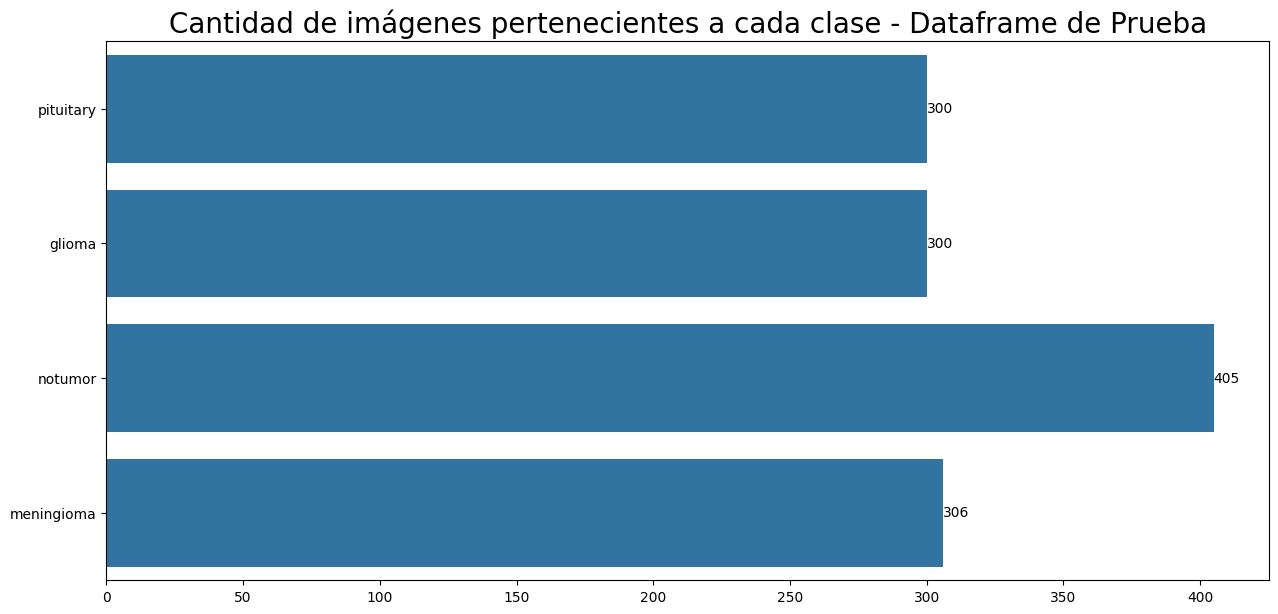

In [ ]:
# Cantidad de imágenes pertenecientes a cada clase - DataFrame de Prueba
# ======================================================================


plt.figure(figsize=(15,7))
ax = sns.countplot(data=ts_df , y=ts_df['Class'])
plt.xlabel('')
plt.ylabel('')
plt.title('Cantidad de imágenes pertenecientes a cada clase - Dataframe de Prueba', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

## División de los datos en entrenamiento, prueba y validación

In [ ]:
# El dataset de validación se obtiene diviendo la mitad del dataset de test

valid_df, ts_df = train_test_split(ts_df, train_size=.5, random_state=20)

In [ ]:
print(f"El dataframe de entranemiento tiene {valid_df.shape[0]} filas y {valid_df.shape[1]} columnas")

El dataframe de entranemiento tiene 655 filas y 2 columnas


## Preprocesamiento de Datos

ImageDataGenerator es una clase utilizada para generar lotes de tensores de imagen con aumentos de datos en tiempo real. Esto es muy útil para el entrenamiento de modelos de redes neuronales, ya que permite ampliar artificialmente el tamaño del dataset aplicando transformaciones aleatorias a las imágenes de entrenamiento.

In [ ]:
batch_size = 16
img_size = (224,224)

* __batch_size:__ define el número de imágenes que se procesarán en cada lote durante el entrenamiento. En este caso, el tamaño del lote es 16.
* __img_size:__ define el tamaño al que se redimensionarán todas las imágenes de entrada. Aquí, las imágenes se redimensionarán a 224x224 píxeles, que es el tamaño predeterminado de la imagen de entrada para este modelo.

In [ ]:
tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))

* __ImageDataGenerator(brightness_range=(.8, 1.2)):__ crea un objeto ImageDataGenerator para el conjunto de entrenamiento. Este generador ajustará el brillo de las imágenes en un rango entre 0.8 y 1.2 del brillo original. Esto es una técnica de aumento de datos que ayuda a mejorar la generalización del modelo al exponerlo a diferentes condiciones de iluminación.

In [ ]:
gen = ImageDataGenerator()

* __ImageDataGenerator()__: crea un objeto ImageDataGenerator sin especificar ningún aumento de datos. Este generador se utilizará para los conjuntos de validación y prueba, donde generalmente no se desea aplicar aumentos para evaluar el rendimiento real del modelo.

### Flujo de imágenes de entrenamiento

In [ ]:
tr_gen = tr_gen.flow_from_dataframe(tr_df, x_col='Class Path',
y_col='Class',batch_size=batch_size,
target_size=img_size)

Found 5712 validated image filenames belonging to 4 classes.


* __tr_gen.flow_from_dataframe(tr_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size):__ crea un flujo de datos de imágenes a partir de un DataFrame tr_df para el entrenamiento.

* __tr_df:__ DataFrame que contiene las rutas a las imágenes (Class Path) y sus etiquetas (Class).
* __x_col:__ nombre de la columna en el DataFrame que contiene las rutas de las imágenes.
* __y_col:__ nombre de la columna en el DataFrame que contiene las etiquetas de las imágenes.
* __batch_size:__ número de imágenes por lote.
* __target_size:__ tamaño al que se redimensionarán las imágenes.

### Flujo de imágenes de validación

In [ ]:
valid_gen = gen.flow_from_dataframe(valid_df, x_col='Class Path',
y_col='Class',batch_size=batch_size,
target_size=img_size)

Found 655 validated image filenames belonging to 4 classes.


* __valid_gen.flow_from_dataframe(valid_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size):__ similar al anterior, pero para el conjunto de validación valid_df.

### Flujo de imágenes de prueba

In [ ]:
ts_gen = gen.flow_from_dataframe(ts_df, x_col='Class Path',
y_col='Class',batch_size=batch_size,
target_size=img_size,shuffle=False)

Found 656 validated image filenames belonging to 4 classes.


* __ts_gen.flow_from_dataframe(ts_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=img_size, shuffle=False):__ crea un flujo de datos de imágenes a partir de un DataFrame ts_df para el conjunto de prueba.
* __shuffle=False:__ asegura que las imágenes no se barajen, lo cual es útil para evaluar el rendimiento del modelo de manera consistente.

## Obtener Muestras de los datos

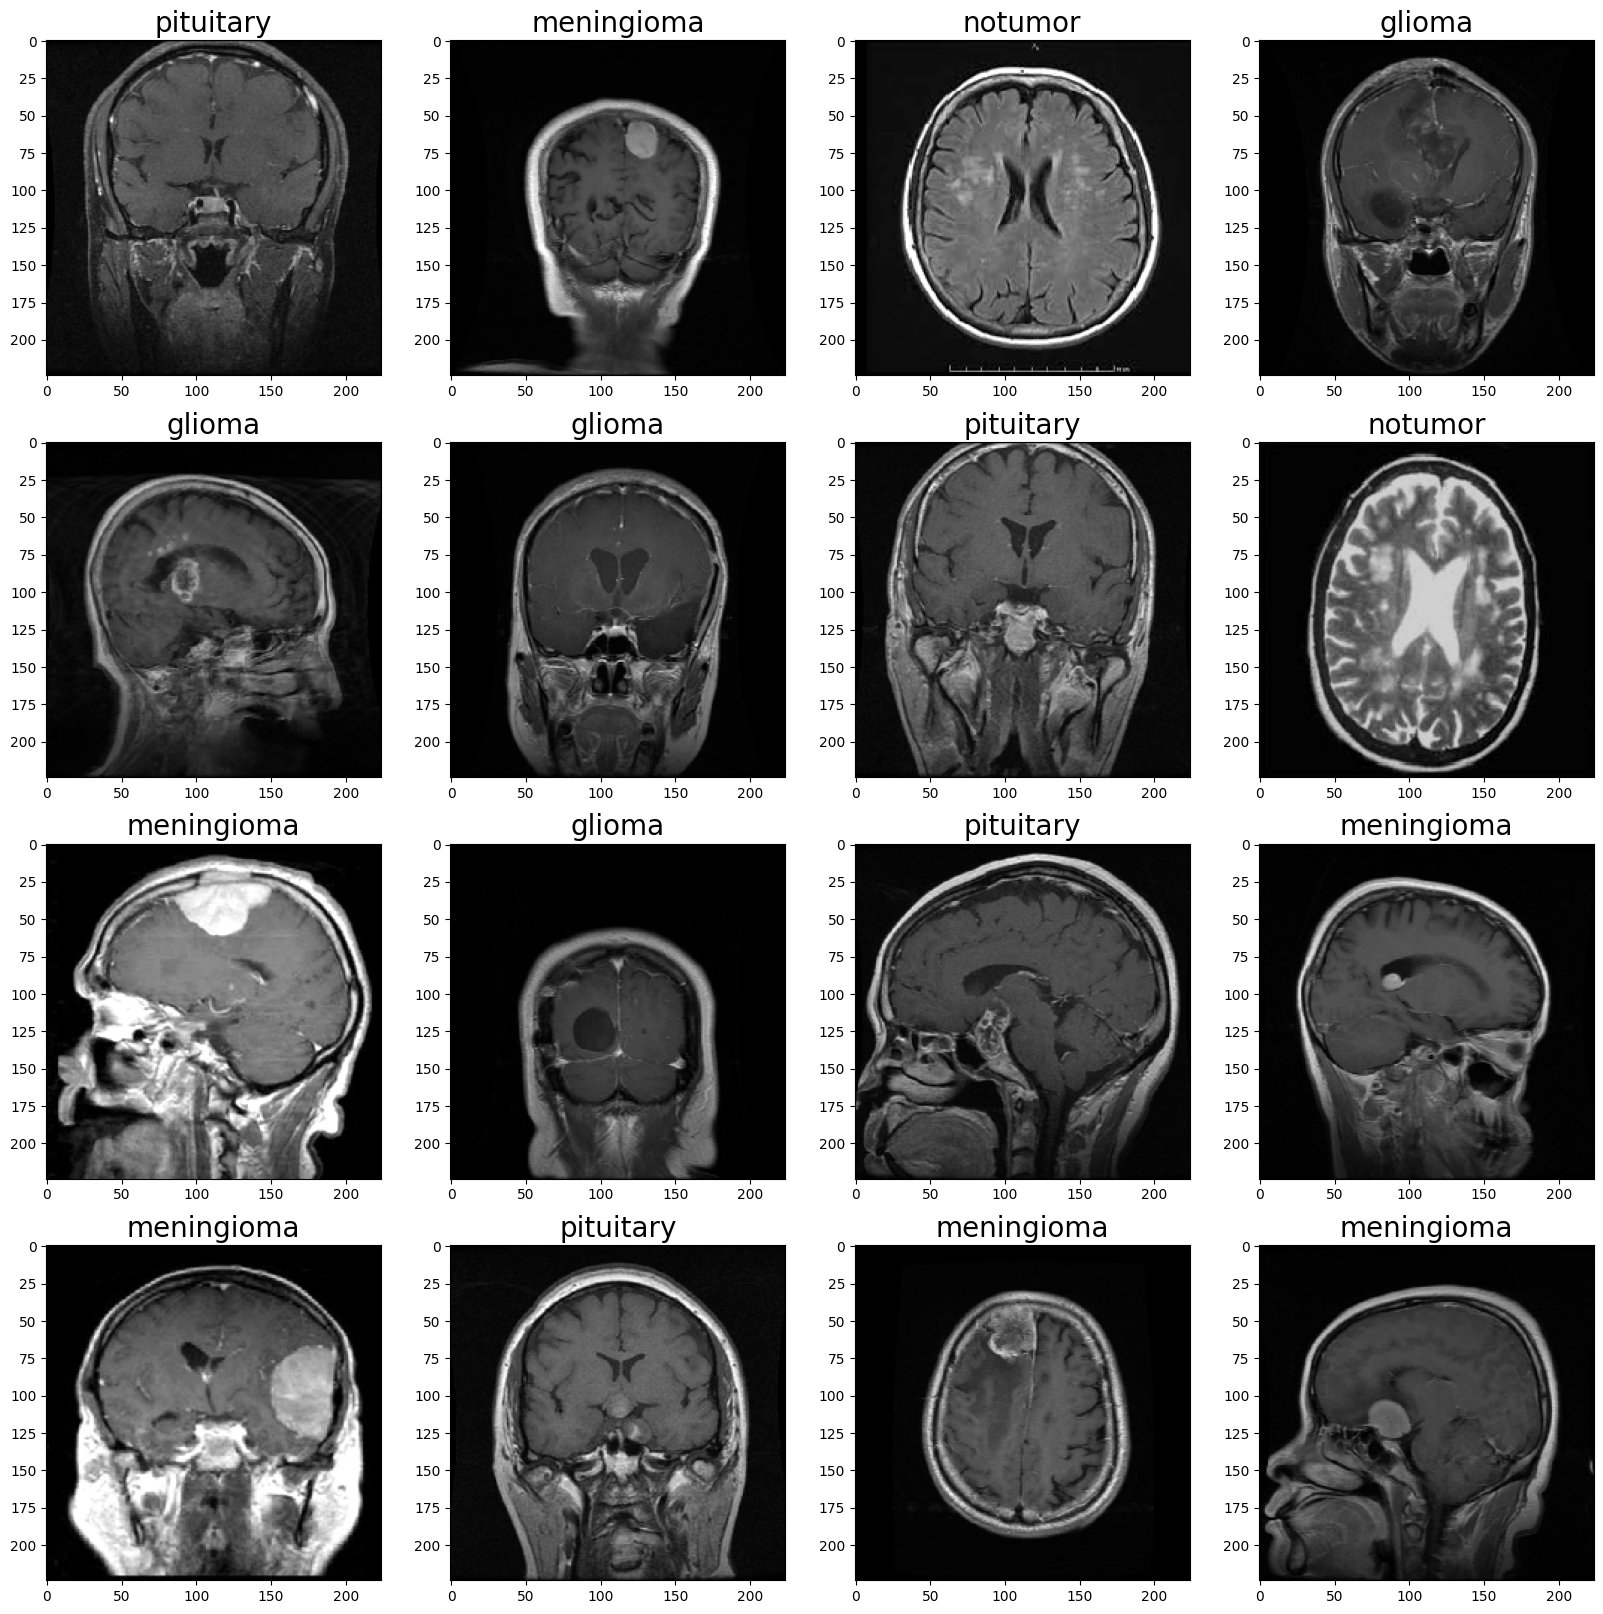

In [ ]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(tr_gen)
plt.figure(figsize= (20, 20))
for i in range(16):
  plt.subplot(4,4,i+1)
  image = images[i] / 255
  plt.imshow(image)
  index = np.argmax(labels[i])
  class_name = classes[index]
  plt.title(class_name, color='k', fontsize=20)
plt.show()

## Modelo 1: Adam LearningRateScheduler




### Creación del Modelo de Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

precision_metric = Precision(name='precision')
recall_metric = Recall(name='recall')

# Definir la forma de entrada
img_shape = (224, 224, 3)

# Cargar el modelo preentrenado ResNet50
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet",
                                            input_shape=img_shape, pooling='max')

# Construir el modelo con una capa de entrada para definir la forma de entrada
input_tensor = tf.keras.Input(shape=img_shape)
x = base_model(input_tensor)
x = Flatten()(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.25)(x)
output_tensor = Dense(4, activation='softmax')(x)

# Crear el modelo
model1 = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# Compilar el modelo con el optimizador Adam
model1.compile(Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       precision_metric,  # Métrica de Precisión
                       recall_metric])    # Métrica de Recall

# Mostrar el resumen del modelo
model1.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                              

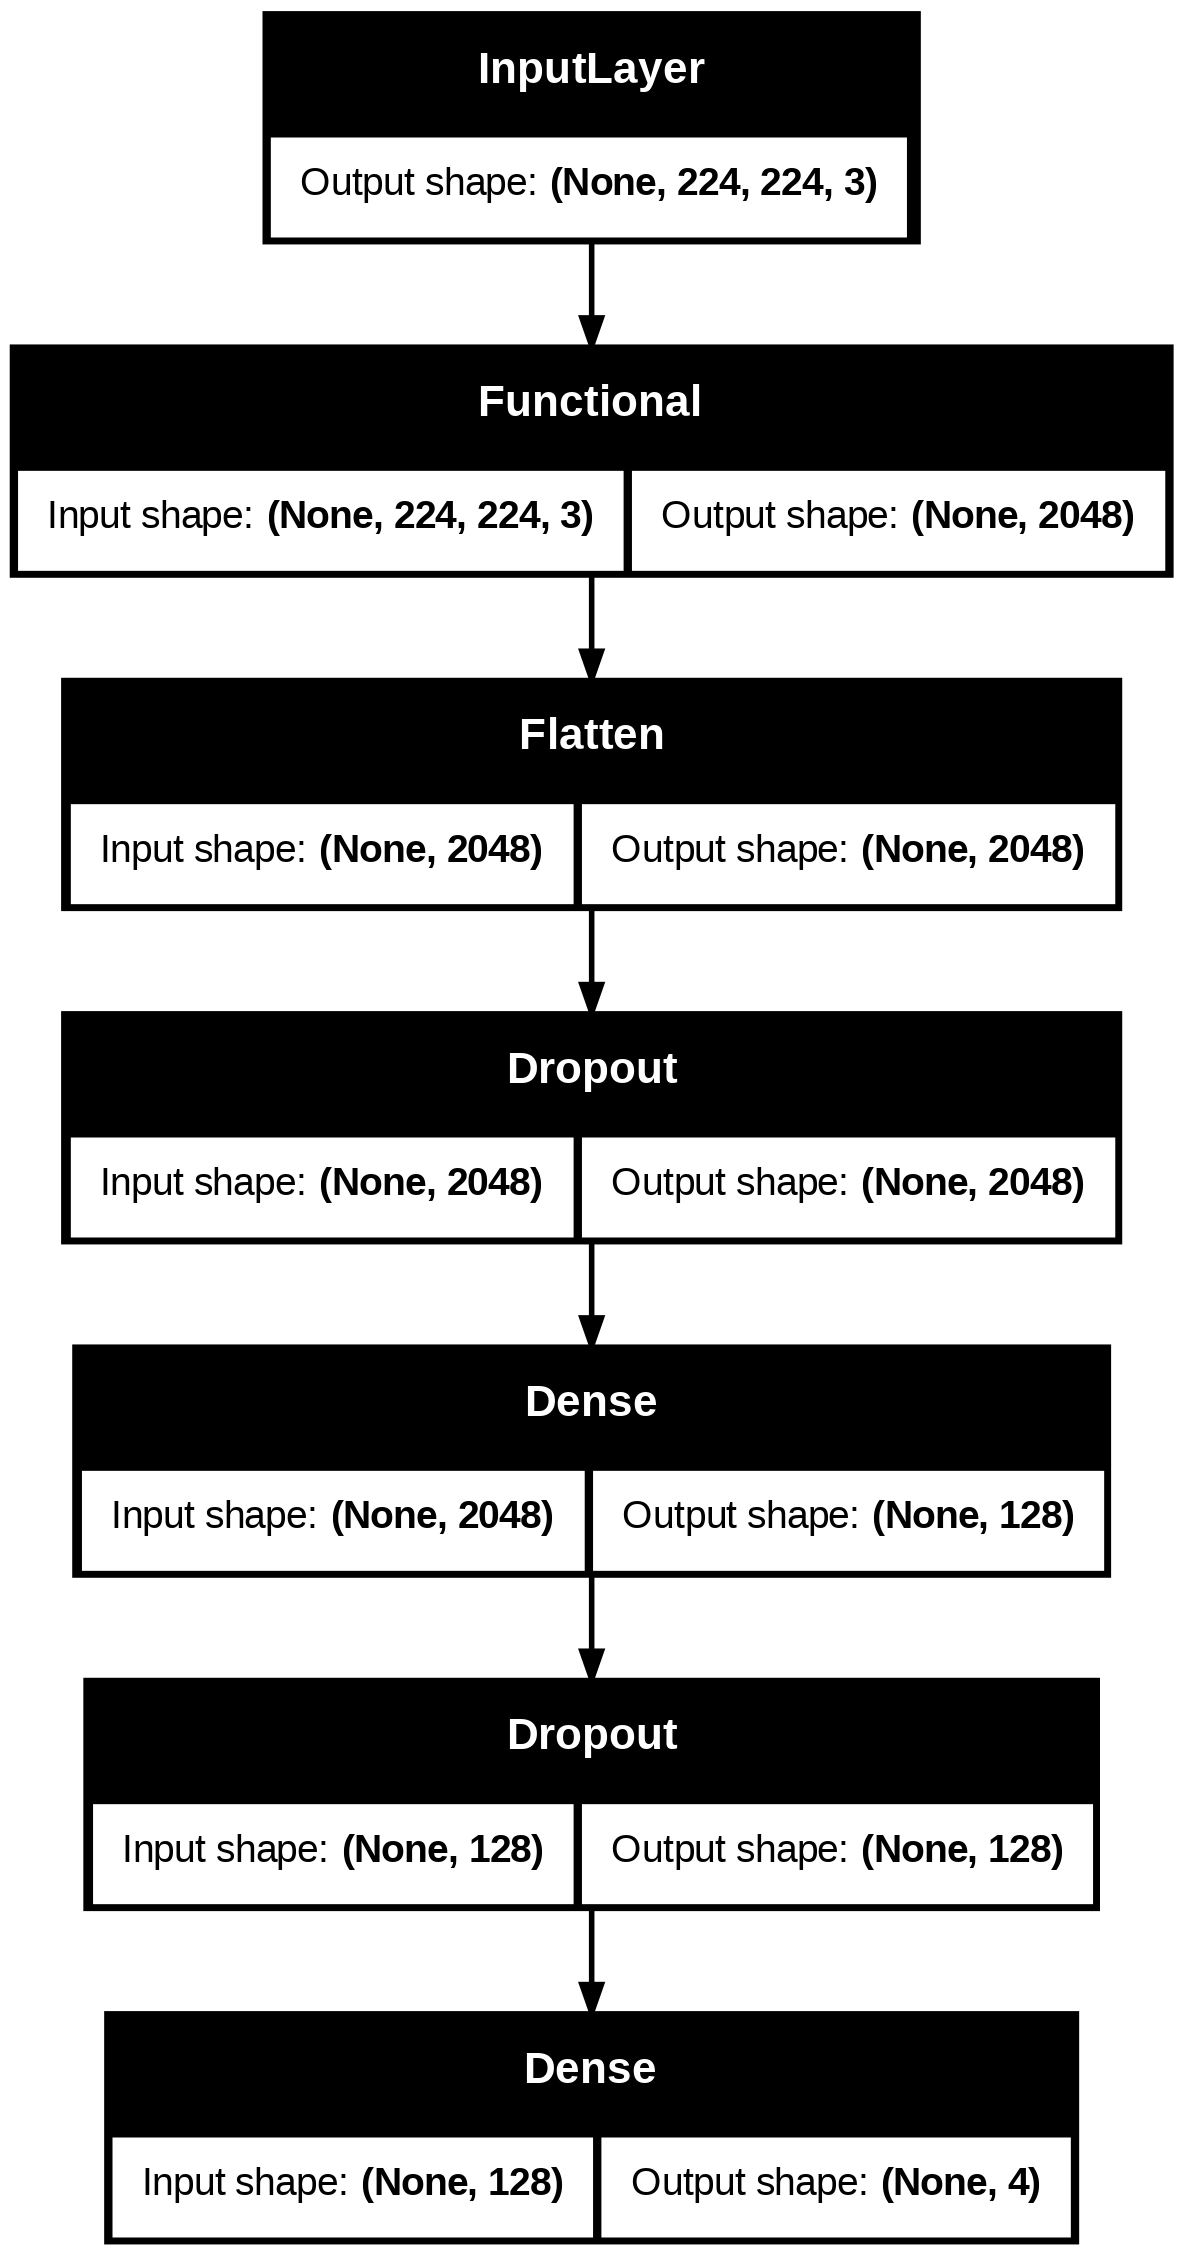

In [ ]:
tf.keras.utils.plot_model(model1, show_shapes=True)

### Entrenamiento

In [ ]:

# Definir la función del scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  # Mantener la tasa de aprendizaje inicial durante las primeras 10 épocas
    else:
        return float(lr * tf.math.exp(-0.1))  # Reducir la tasa de aprendizaje exponencialmente después de la época 10

# Crear el callback del scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Entrenar el modelo con el LearningRateScheduler
hist1 = model1.fit(
    tr_gen,
    epochs=15,
    validation_data=valid_gen,
    shuffle=False,
    callbacks=[lr_scheduler]  # Añadir el callback del scheduler
)



Epoch 1/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 1851s 5s/step - accuracy: 0.6945 - loss: 2.2908 - precision: 0.7187 - recall: 0.6527 - val_accuracy: 0.5832 - val_loss: 1.1830 - val_precision: 0.5888 - val_recall: 0.5771 - learning_rate: 0.0010
Epoch 2/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.8508 - loss: 0.4565 - precision: 0.8779 - recall: 0.8129 - val_accuracy: 0.6977 - val_loss: 0.9883 - val_precision: 0.7634 - val_recall: 0.6748 - learning_rate: 0.0010
Epoch 3/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.8859 - loss: 0.3721 - precision: 0.9057 - recall: 0.8623 - val_accuracy: 0.7481 - val_loss: 0.7391 - val_precision: 0.7780 - val_recall: 0.7328 - learning_rate: 0.0010
Epoch 4/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 467s 1s/step - accuracy: 0.9134 - loss: 0.2780 - precision: 0.9282 - recall: 0.8828 - val_accuracy: 0.5359 - val_loss: 1.4529 - val_precision: 0.5430 - val_recall: 0.5206 - learning_rate: 0.0010
Epoch 5/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - accu

In [ ]:
hist1.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

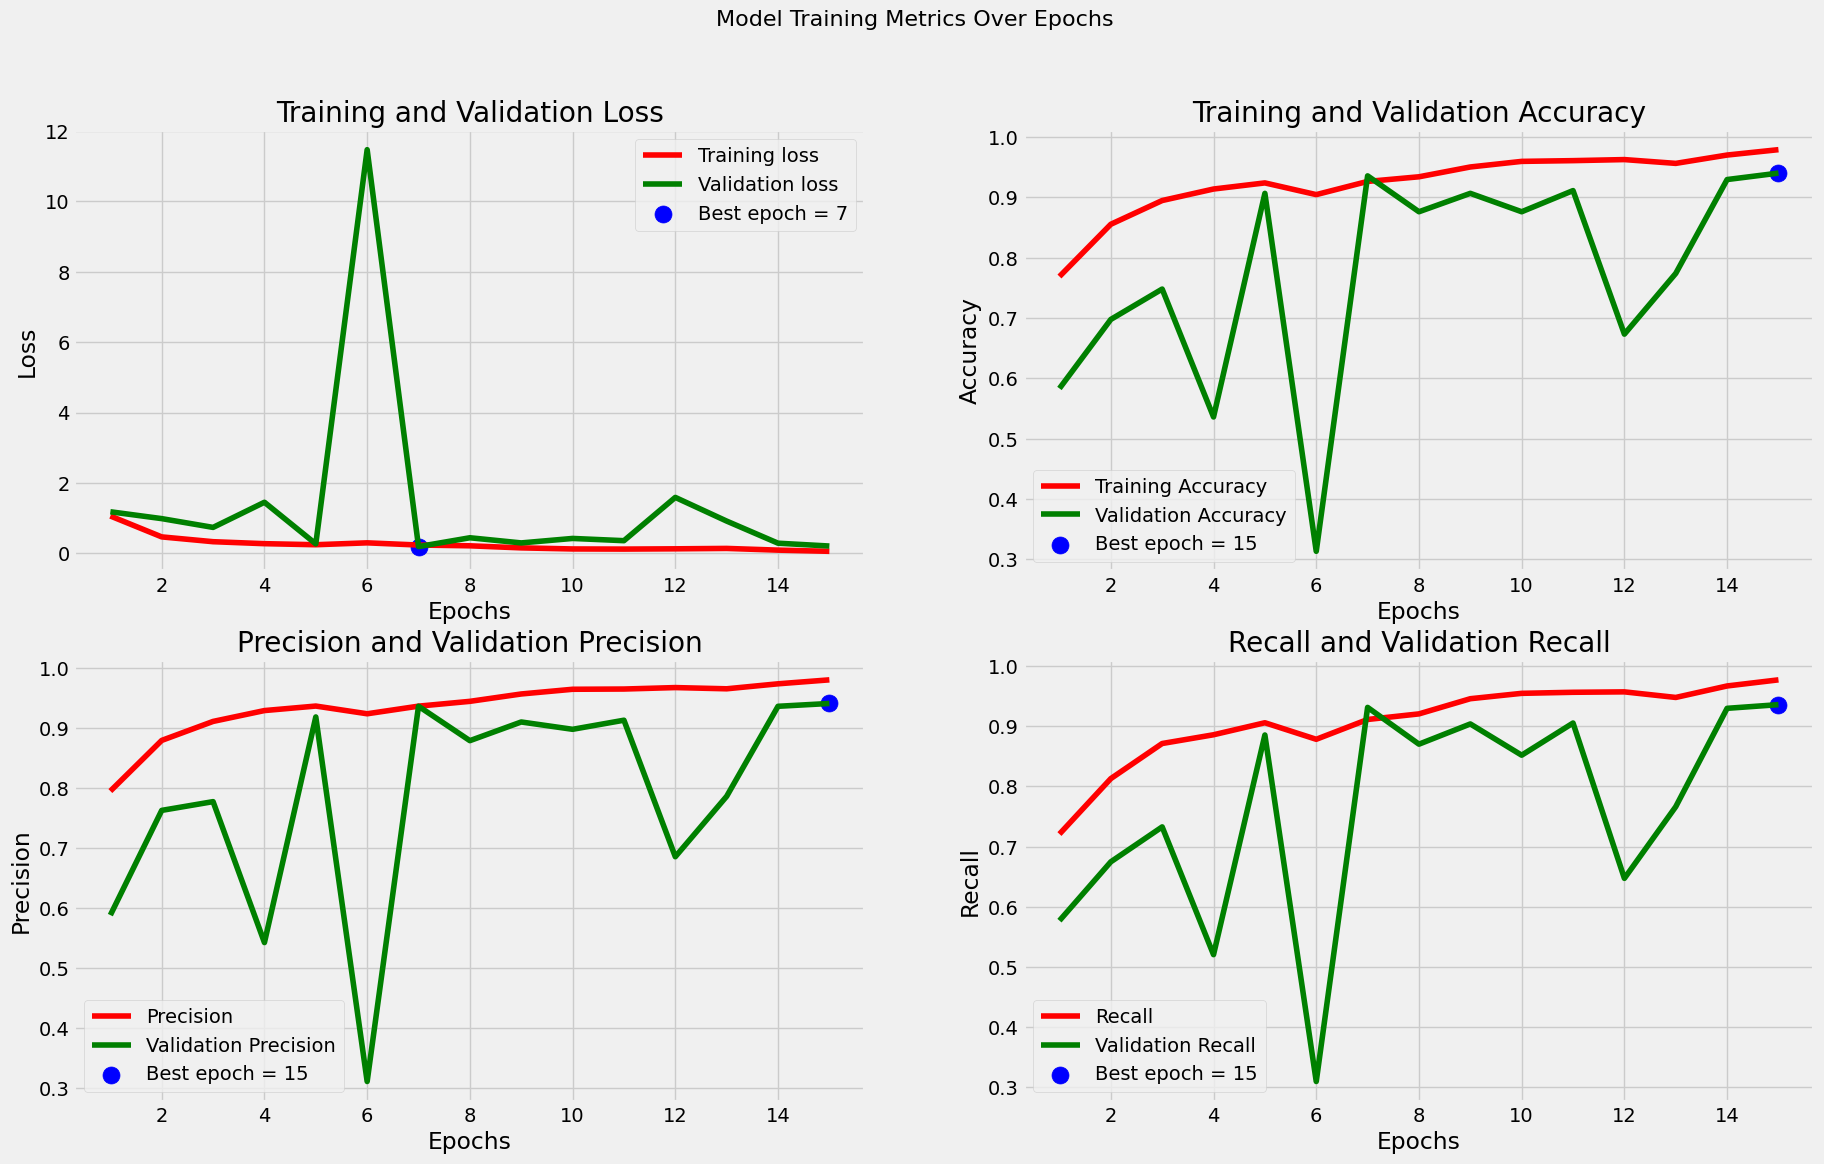

In [ ]:
tr_acc = hist1.history['accuracy']
tr_loss = hist1.history['loss']
tr_per = hist1.history['precision']
tr_recall = hist1.history['recall']
val_acc = hist1.history['val_accuracy']
val_loss = hist1.history['val_loss']
val_per = hist1.history['val_precision']
val_recall = hist1.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# Usar PdfPages para crear archivos PDF para cada gráfico
with PdfPages('training_validation_loss_1.pdf') as pdf:
    plt.figure(figsize=(10, 6))  # Tamaño ajustado
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Ajustar para mejor centrado
    pdf.savefig()  # Guardar la figura actual en el PDF
    plt.close()

with PdfPages('training_validation_accuracy_1.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

with PdfPages('training_validation_precision_1.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_per, 'r', label='Precision')
    plt.plot(Epochs, val_per, 'g', label='Validation Precision')
    plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

with PdfPages('training_validation_recall_1.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_recall, 'r', label='Recall')
    plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
    plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

### Pruebas y Evaluación

### Evaluación

In [ ]:
train_score = model1.evaluate(tr_gen, verbose= 1)
valid_score = model1.evaluate(valid_gen, verbose= 1)
test_score = model1.evaluate(ts_gen, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 88s 245ms/step - accuracy: 0.9633 - loss: 0.1366 - precision: 0.9649 - recall: 0.9629
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.9364 - loss: 0.2079 - precision: 0.9370 - recall: 0.9340
41/41 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step - accuracy: 0.9209 - loss: 0.3373 - precision: 0.9261 - recall: 0.9122
Train Loss:  0.14230424165725708
Train Accuracy:  0.9606092572212219
--------------------
Validation Loss:  0.209800586104393
Validation Accuracy:  0.9404579997062683
--------------------
Test Loss:  0.2647790312767029
Test Accuracy:  0.9268292784690857


In [ ]:
preds = model1.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step


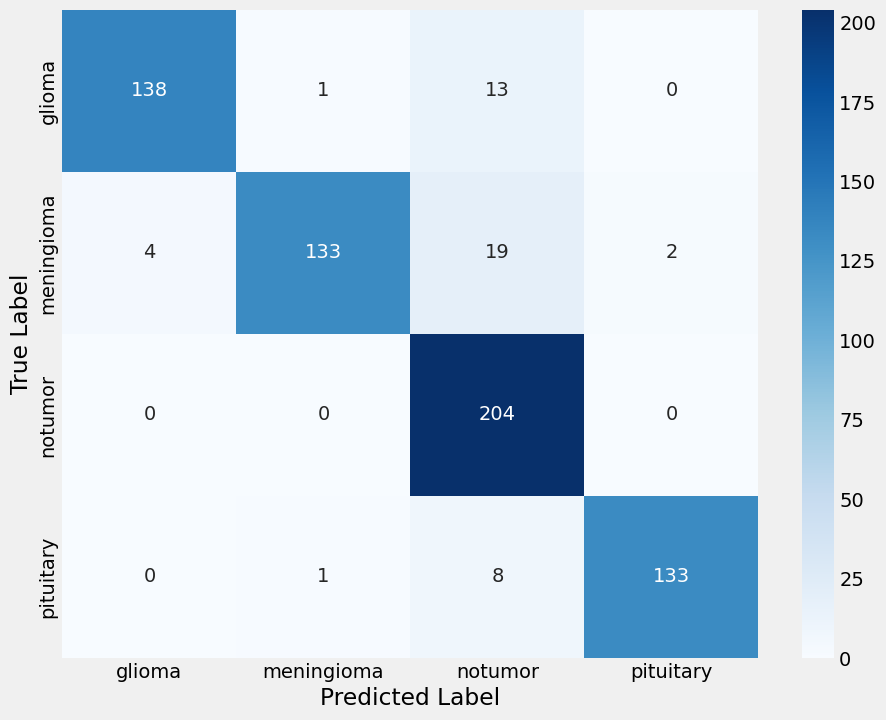

In [ ]:
# A partir de las predicciones (y_pred) y las clases verdaderas (ts_gen.classes)
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Guardar la matriz de confusión en un archivo PDF
with PdfPages('confusion_matrix_1.pdf') as pdf:
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    pdf.savefig()  # Guarda el gráfico en el archivo PDF
    plt.close()


In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       152
           1       0.99      0.84      0.91       158
           2       0.84      1.00      0.91       204
           3       0.99      0.94      0.96       142

    accuracy                           0.93       656
   macro avg       0.94      0.92      0.93       656
weighted avg       0.94      0.93      0.93       656



### Prueba

In [ ]:
def predict(img_path):
  import numpy as np
  import matplotlib.pyplot as plt
  from PIL import Image
  label = list(class_dict.keys())
  plt.figure(figsize=(12, 12))
  img = Image.open(img_path)
  resized_img = img.resize((224, 224))
  img = np.asarray(resized_img)
  img = np.expand_dims(img, axis=0)
  predictions = model1.predict(img)
  probs = list(predictions[0])
  labels = label
  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probs)
  plt.xlabel('Probability', fontsize=15)
  ax = plt.gca()
  ax.bar_label(bars, fmt = '%.2f')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


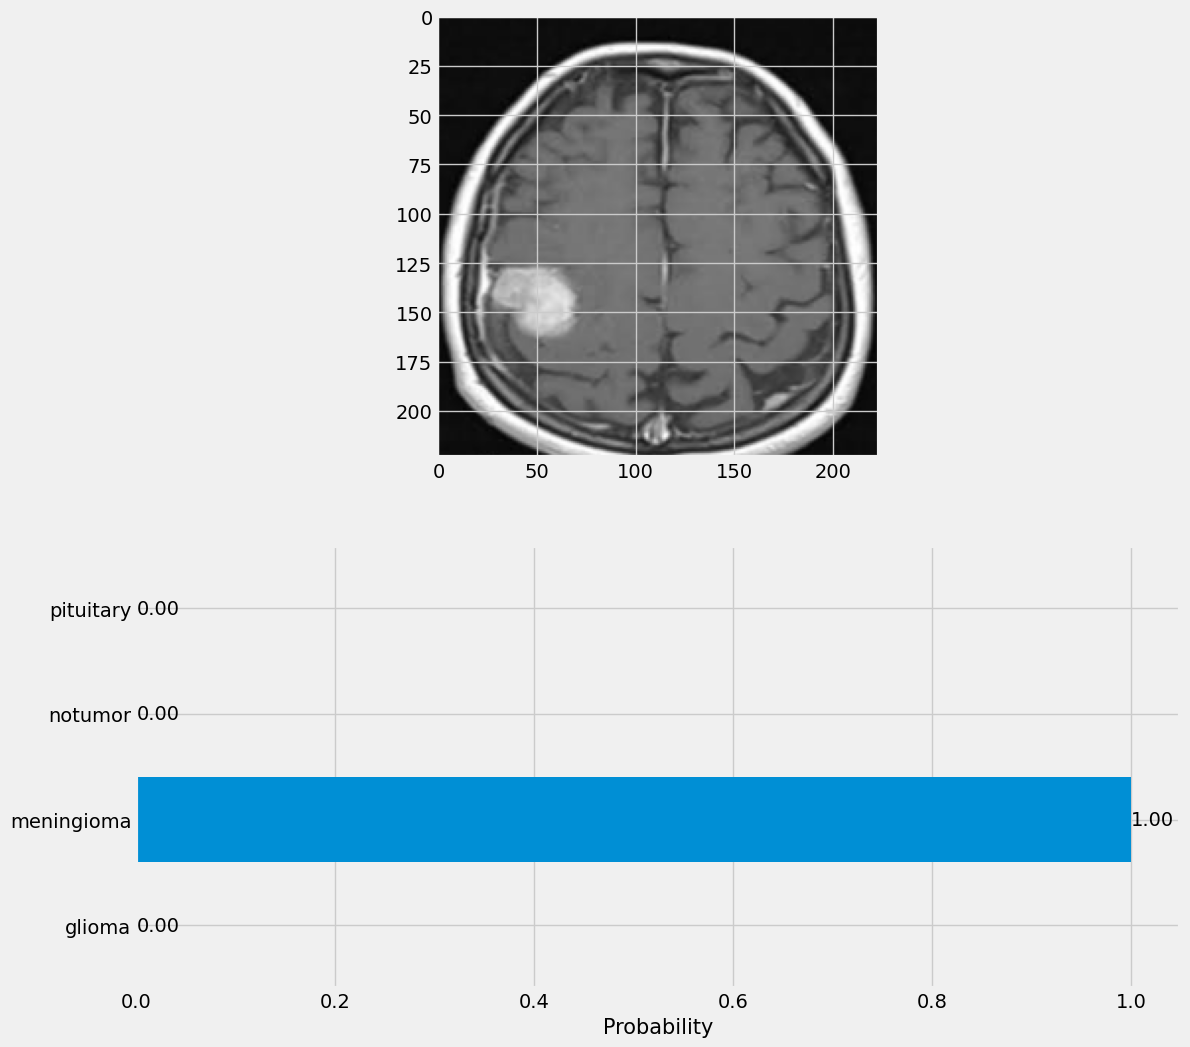

In [ ]:
predict("/content/drive/MyDrive/Tumor_Brain/Testing/meningioma/Te-me_0023.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


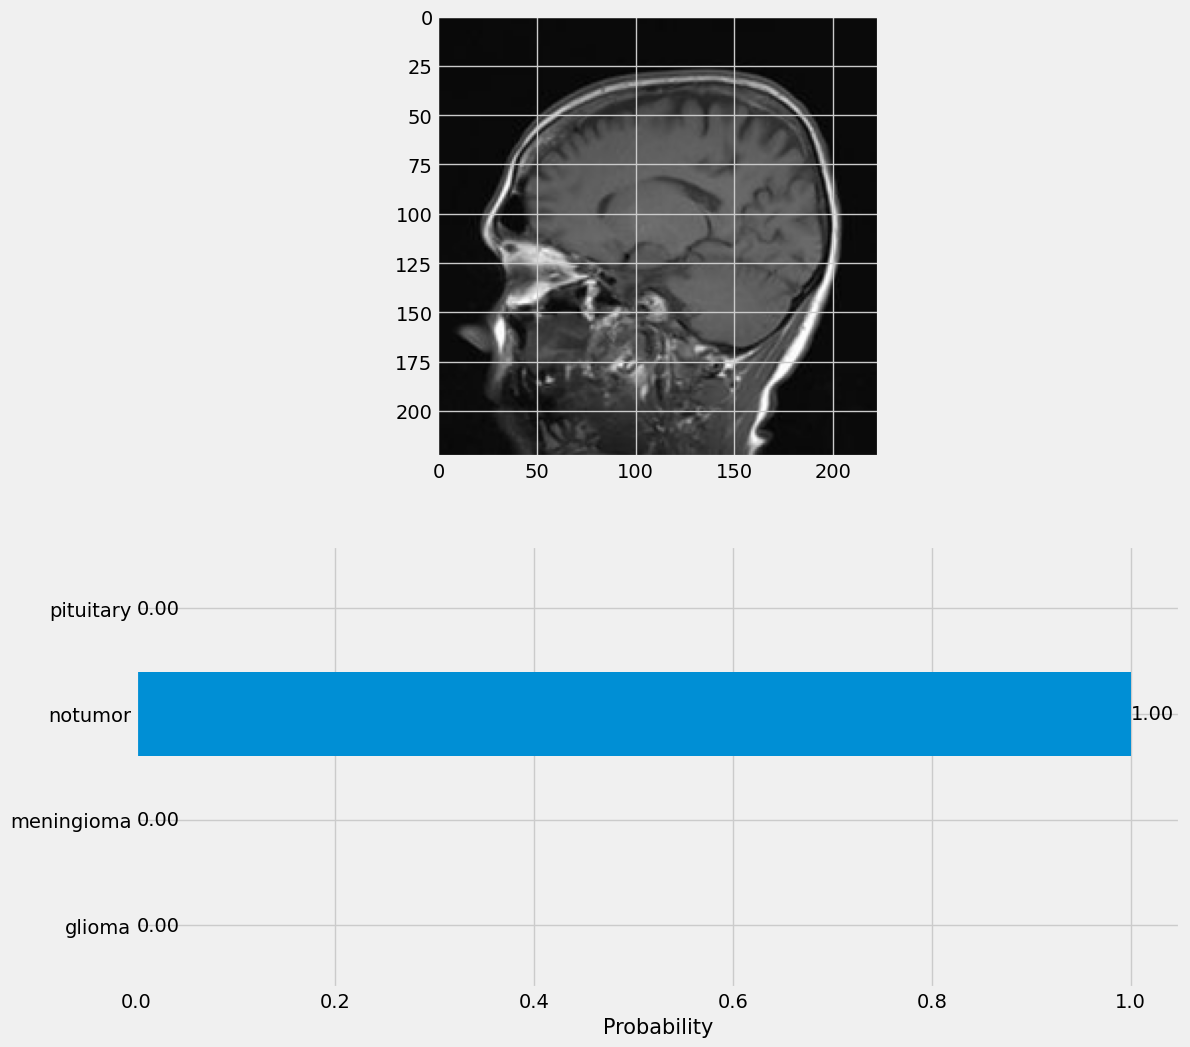

In [ ]:
predict("/content/drive/MyDrive/Tumor_Brain/Testing/notumor/Te-no_0015.jpg")

## Modelo 2: SGD LearningRateScheduler

### Creación del Modelo de Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

precision_metric = Precision(name='precision')
recall_metric = Recall(name='recall')

# Definir la forma de entrada
img_shape = (224, 224, 3)

# Cargar el modelo preentrenado ResNet50
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet",
                                            input_shape=img_shape, pooling='max')

# Construir el modelo con una capa de entrada para definir la forma de entrada
input_tensor = tf.keras.Input(shape=img_shape)
x = base_model(input_tensor)
x = Flatten()(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.25)(x)
output_tensor = Dense(4, activation='softmax')(x)

# Crear el modelo
model3 = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# Compilar el modelo con el optimizador SGD con momentum 0.95
model3.compile(SGD(learning_rate=0.001, momentum=0.95),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       precision_metric,
                       recall_metric])

# Mostrar el resumen del modelo
model3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 516 

In [ ]:
tf.keras.utils.plot_model(model3, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Entrenamiento

In [ ]:

# Definir la función del scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  # Mantener la tasa de aprendizaje inicial durante las primeras 10 épocas
    else:
        return float(lr * tf.math.exp(-0.1))  # Reducir la tasa de aprendizaje exponencialmente después de la época 10

# Crear el callback del scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Entrenar el modelo con el LearningRateScheduler
hist3 = model3.fit(
    tr_gen,
    epochs=15,
    validation_data=valid_gen,
    shuffle=False,
    callbacks=[lr_scheduler]  # Añadir el callback del scheduler
)



Epoch 1/15
357/357 [==============================] - 378s 1s/step - loss: 1.0657 - accuracy: 0.7244 - precision: 0.8304 - recall: 0.5804 - val_loss: 0.4029 - val_accuracy: 0.8809 - val_precision: 0.9100 - val_recall: 0.8489 - lr: 0.0010
Epoch 2/15
357/357 [==============================] - 366s 1s/step - loss: 0.4353 - accuracy: 0.8589 - precision: 0.9381 - recall: 0.7754 - val_loss: 0.6532 - val_accuracy: 0.8519 - val_precision: 0.8790 - val_recall: 0.7542 - lr: 0.0010
Epoch 3/15
357/357 [==============================] - 366s 1s/step - loss: 0.3436 - accuracy: 0.8967 - precision: 0.9525 - recall: 0.8107 - val_loss: 0.2680 - val_accuracy: 0.9252 - val_precision: 0.9447 - val_recall: 0.8351 - lr: 0.0010
Epoch 4/15
357/357 [==============================] - 368s 1s/step - loss: 0.2730 - accuracy: 0.9154 - precision: 0.9605 - recall: 0.8384 - val_loss: 0.1976 - val_accuracy: 0.9588 - val_precision: 0.9766 - val_recall: 0.8916 - lr: 0.0010
Epoch 5/15
357/357 [============================

In [ ]:
hist3.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])

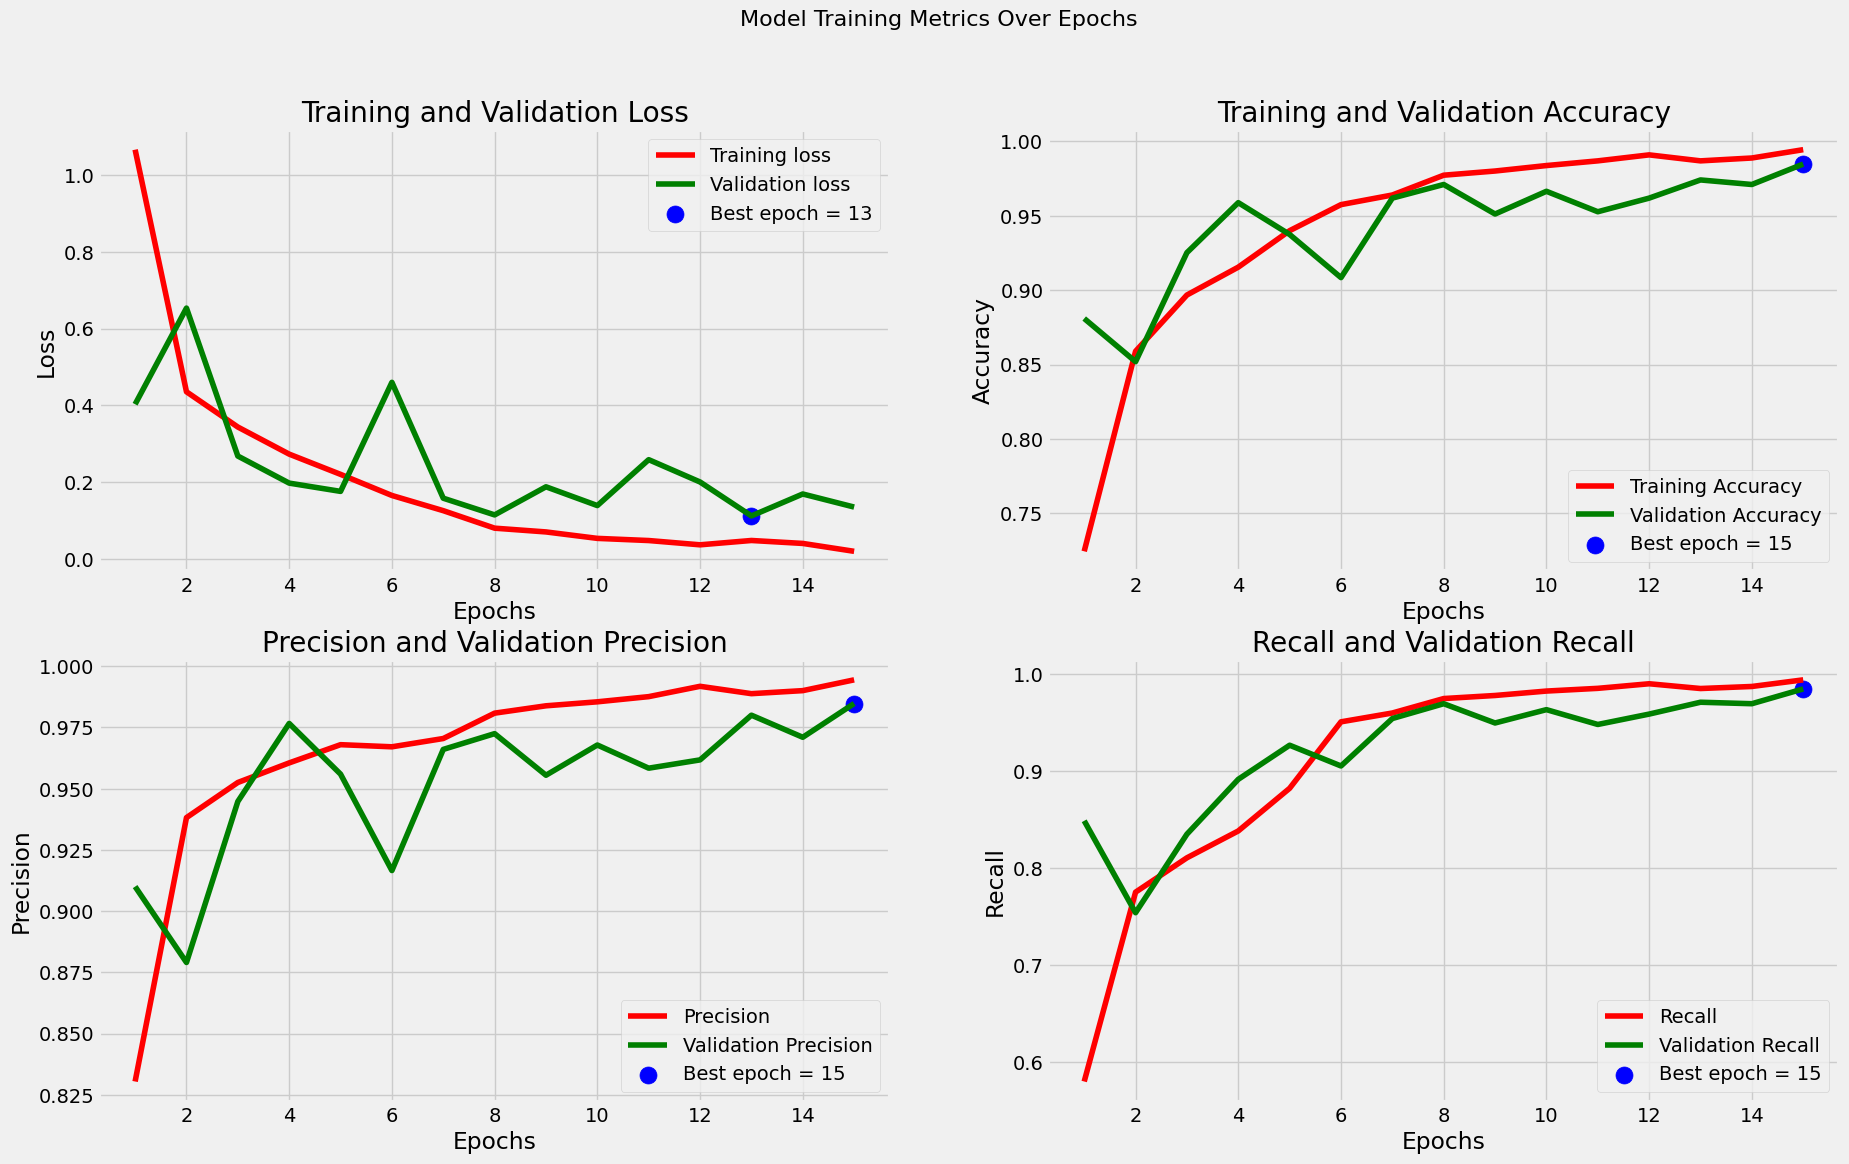

In [ ]:
tr_acc = hist3.history['accuracy']
tr_loss = hist3.history['loss']
tr_per = hist3.history['precision']
tr_recall = hist3.history['recall']
val_acc = hist3.history['val_accuracy']
val_loss = hist3.history['val_loss']
val_per = hist3.history['val_precision']
val_recall = hist3.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# Usar PdfPages para crear archivos PDF para cada gráfico
with PdfPages('training_validation_loss_3.pdf') as pdf:
    plt.figure(figsize=(10, 6))  # Tamaño ajustado
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Ajustar para mejor centrado
    pdf.savefig()  # Guardar la figura actual en el PDF
    plt.close()

with PdfPages('training_validation_accuracy_3.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

with PdfPages('training_validation_precision_3.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_per, 'r', label='Precision')
    plt.plot(Epochs, val_per, 'g', label='Validation Precision')
    plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

with PdfPages('training_validation_recall_3.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_recall, 'r', label='Recall')
    plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
    plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

### Pruebas y Evaluación

### Evaluación

In [ ]:
train_score = model3.evaluate(tr_gen, verbose= 1)
valid_score = model3.evaluate(valid_gen, verbose= 1)
test_score = model3.evaluate(ts_gen, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 9s 217ms/step - loss: 0.0508 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9909
Train Loss:  0.0018943470204249024
Train Accuracy:  0.9992997050285339
--------------------
Validation Loss:  0.135233536362648
Validation Accuracy:  0.9847328066825867
--------------------
Test Loss:  0.050755809992551804
Test Accuracy:  0.9923780560493469


In [ ]:
preds = model3.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 11s 230ms/step


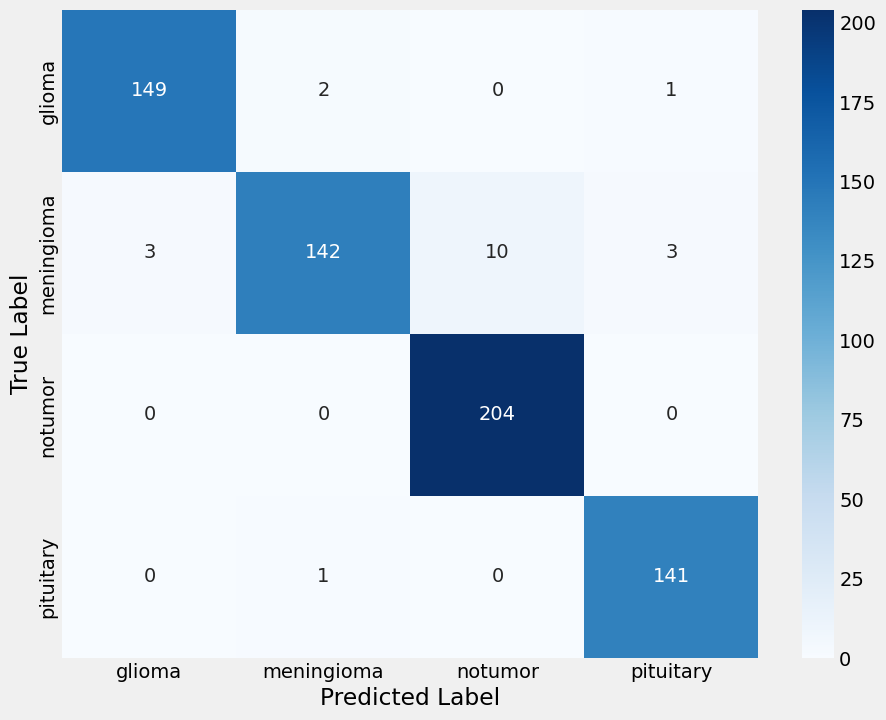

In [ ]:
# A partir de las predicciones (y_pred) y las clases verdaderas (ts_gen.classes)
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Guardar la matriz de confusión en un archivo PDF
with PdfPages('confusion_matrix_3.pdf') as pdf:
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    pdf.savefig()  # Guarda el gráfico en el archivo PDF
    plt.close()


In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       152
           1       0.98      0.99      0.99       158
           2       1.00      1.00      1.00       204
           3       0.99      1.00      0.99       142

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



### Prueba

In [ ]:
def predict(img_path):
  import numpy as np
  import matplotlib.pyplot as plt
  from PIL import Image
  label = list(class_dict.keys())
  plt.figure(figsize=(12, 12))
  img = Image.open(img_path)
  resized_img = img.resize((224, 224))
  img = np.asarray(resized_img)
  img = np.expand_dims(img, axis=0)
  predictions = model3.predict(img)
  probs = list(predictions[0])
  labels = label
  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probs)
  plt.xlabel('Probability', fontsize=15)
  ax = plt.gca()
  ax.bar_label(bars, fmt = '%.2f')
  plt.show()

1/1 [==============================] - 1s 978ms/step


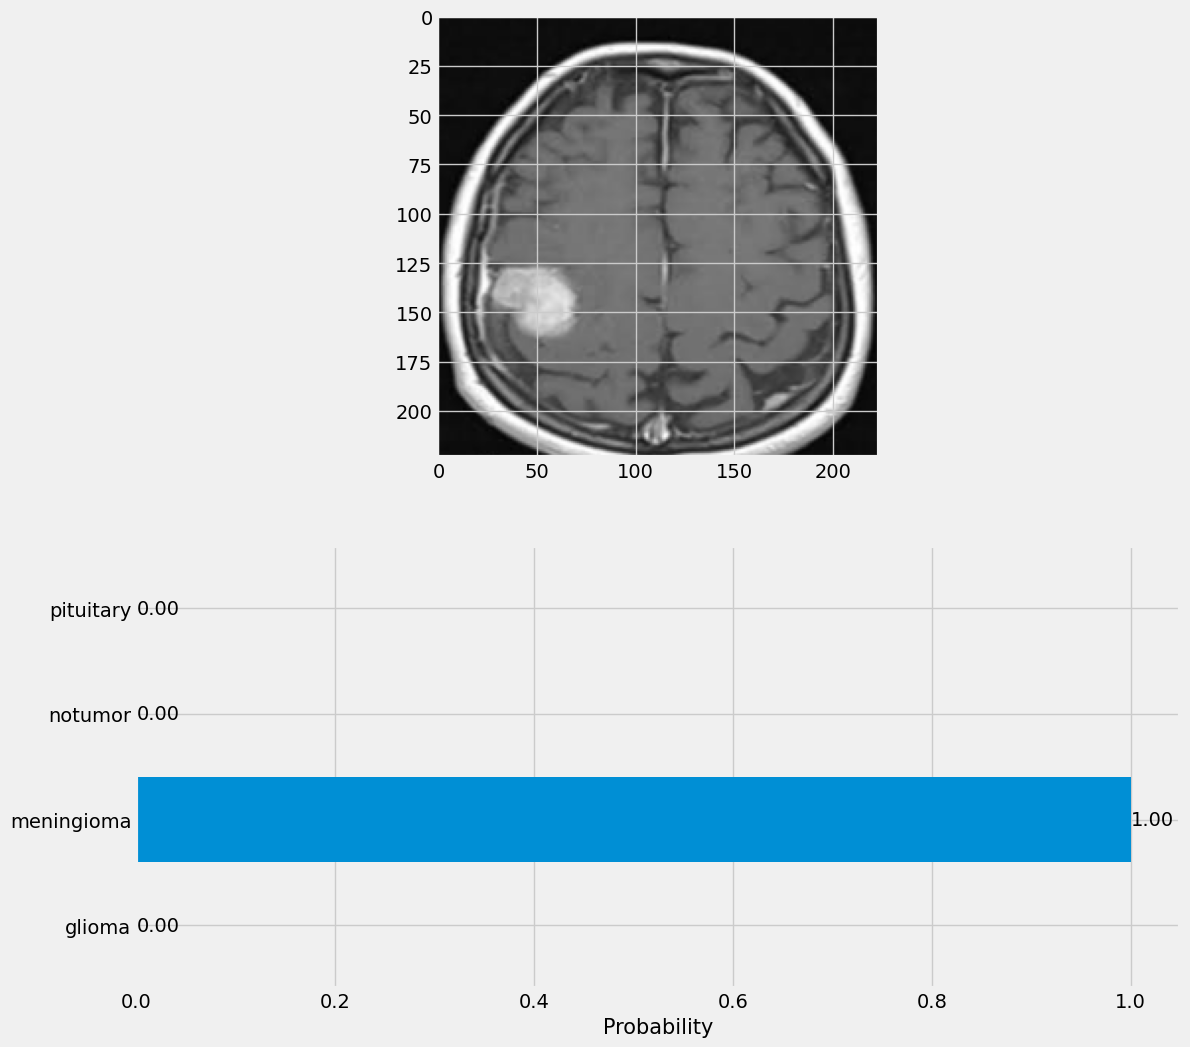

In [ ]:
predict("/content/drive/MyDrive/Tumor_Brain/Testing/meningioma/Te-me_0023.jpg")

1/1 [==============================] - 0s 83ms/step


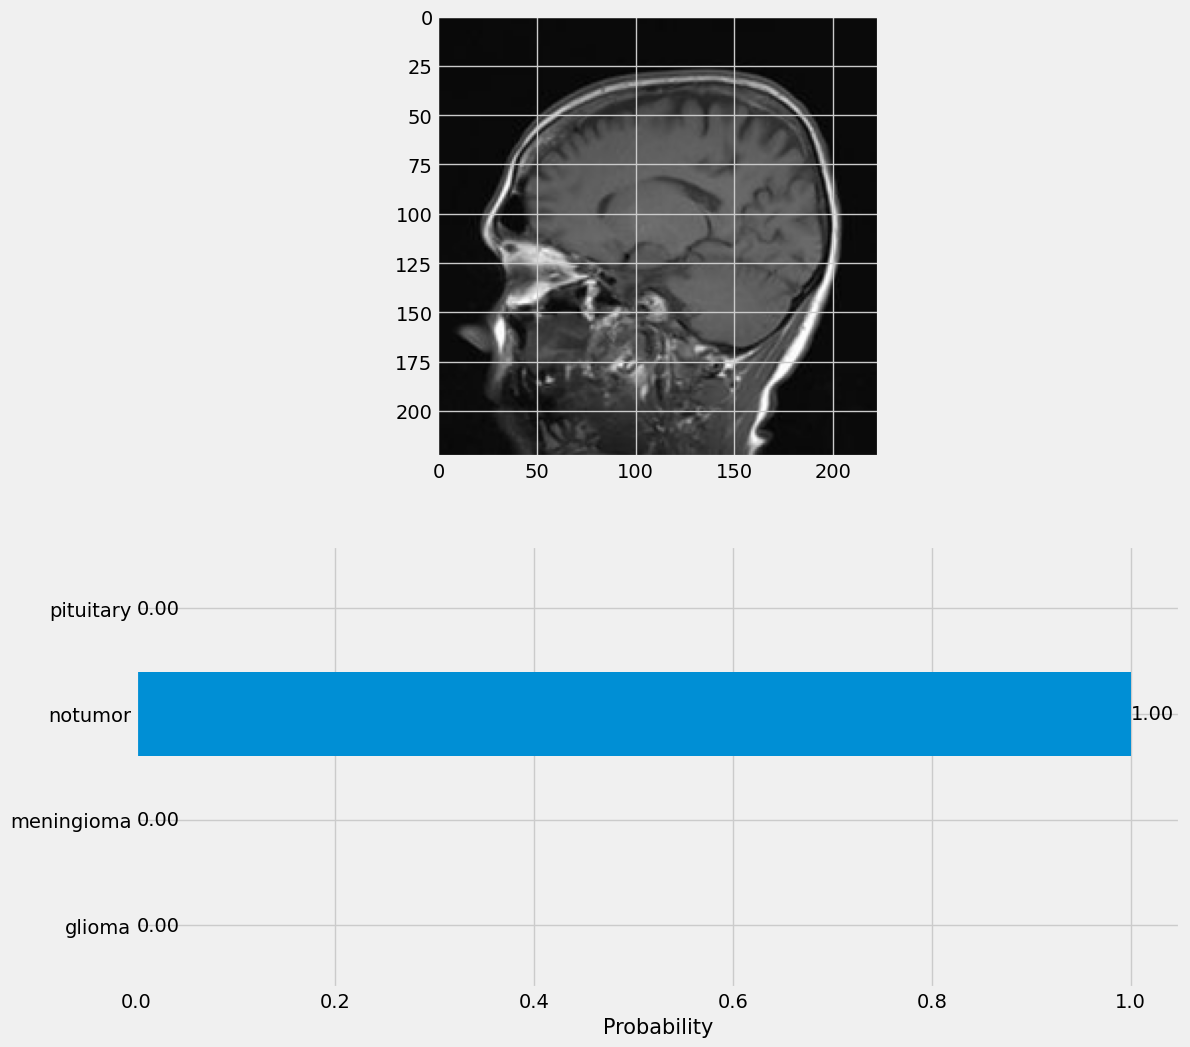

In [ ]:
predict("/content/drive/MyDrive/Tumor_Brain/Testing/notumor/Te-no_0015.jpg")

## Modelo 3: SGD MultiStepLr

### Creación del Modelo de Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

precision_metric = Precision(name='precision')
recall_metric = Recall(name='recall')

# Definir la forma de entrada
img_shape = (224, 224, 3)

# Cargar el modelo preentrenado ResNet50
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet",
                                            input_shape=img_shape, pooling='max')

# Construir el modelo con una capa de entrada para definir la forma de entrada
input_tensor = tf.keras.Input(shape=img_shape)
x = base_model(input_tensor)
x = Flatten()(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.25)(x)
output_tensor = Dense(4, activation='softmax')(x)

# Crear el modelo
model4 = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# Compilar el modelo con el optimizador SGD
model4.compile(SGD(learning_rate=0.001, momentum=0.95),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       precision_metric,  # Métrica de Precisión
                       recall_metric])    # Métrica de Recall

# Mostrar el resumen del modelo
model4.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_12 (Dropout)        (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 4)                 516 

In [ ]:
tf.keras.utils.plot_model(model4, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Entrenamiento

In [ ]:
# Definir los hitos y el factor de decaimiento
milestones = [5, 10]
decay_factor = 0.1

# Definir la función del scheduler
def scheduler(epoch, lr):
    if epoch in milestones:
        return lr * decay_factor
    return lr

# Crear el callback del scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Entrenar el modelo
hist4 = model4.fit(
    tr_gen,
    epochs=15,
    validation_data=valid_gen,
    shuffle=False,
    callbacks=[lr_scheduler]
)


Epoch 1/15
357/357 [==============================] - 371s 1s/step - loss: 0.4168 - accuracy: 0.8734 - precision: 0.9145 - recall: 0.8037 - val_loss: 0.3189 - val_accuracy: 0.8931 - val_precision: 0.9391 - val_recall: 0.8244 - lr: 0.0010
Epoch 2/15
357/357 [==============================] - 372s 1s/step - loss: 0.2607 - accuracy: 0.9214 - precision: 0.9448 - recall: 0.8689 - val_loss: 0.2346 - val_accuracy: 0.9298 - val_precision: 0.9629 - val_recall: 0.8718 - lr: 0.0010
Epoch 3/15
357/357 [==============================] - 372s 1s/step - loss: 0.2624 - accuracy: 0.9221 - precision: 0.9519 - recall: 0.8636 - val_loss: 0.1964 - val_accuracy: 0.9130 - val_precision: 0.9453 - val_recall: 0.8977 - lr: 0.0010
Epoch 4/15
357/357 [==============================] - 371s 1s/step - loss: 0.2019 - accuracy: 0.9401 - precision: 0.9629 - recall: 0.8986 - val_loss: 0.4091 - val_accuracy: 0.8565 - val_precision: 0.8794 - val_recall: 0.8351 - lr: 0.0010
Epoch 5/15
357/357 [============================

In [ ]:
hist4.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'lr'])

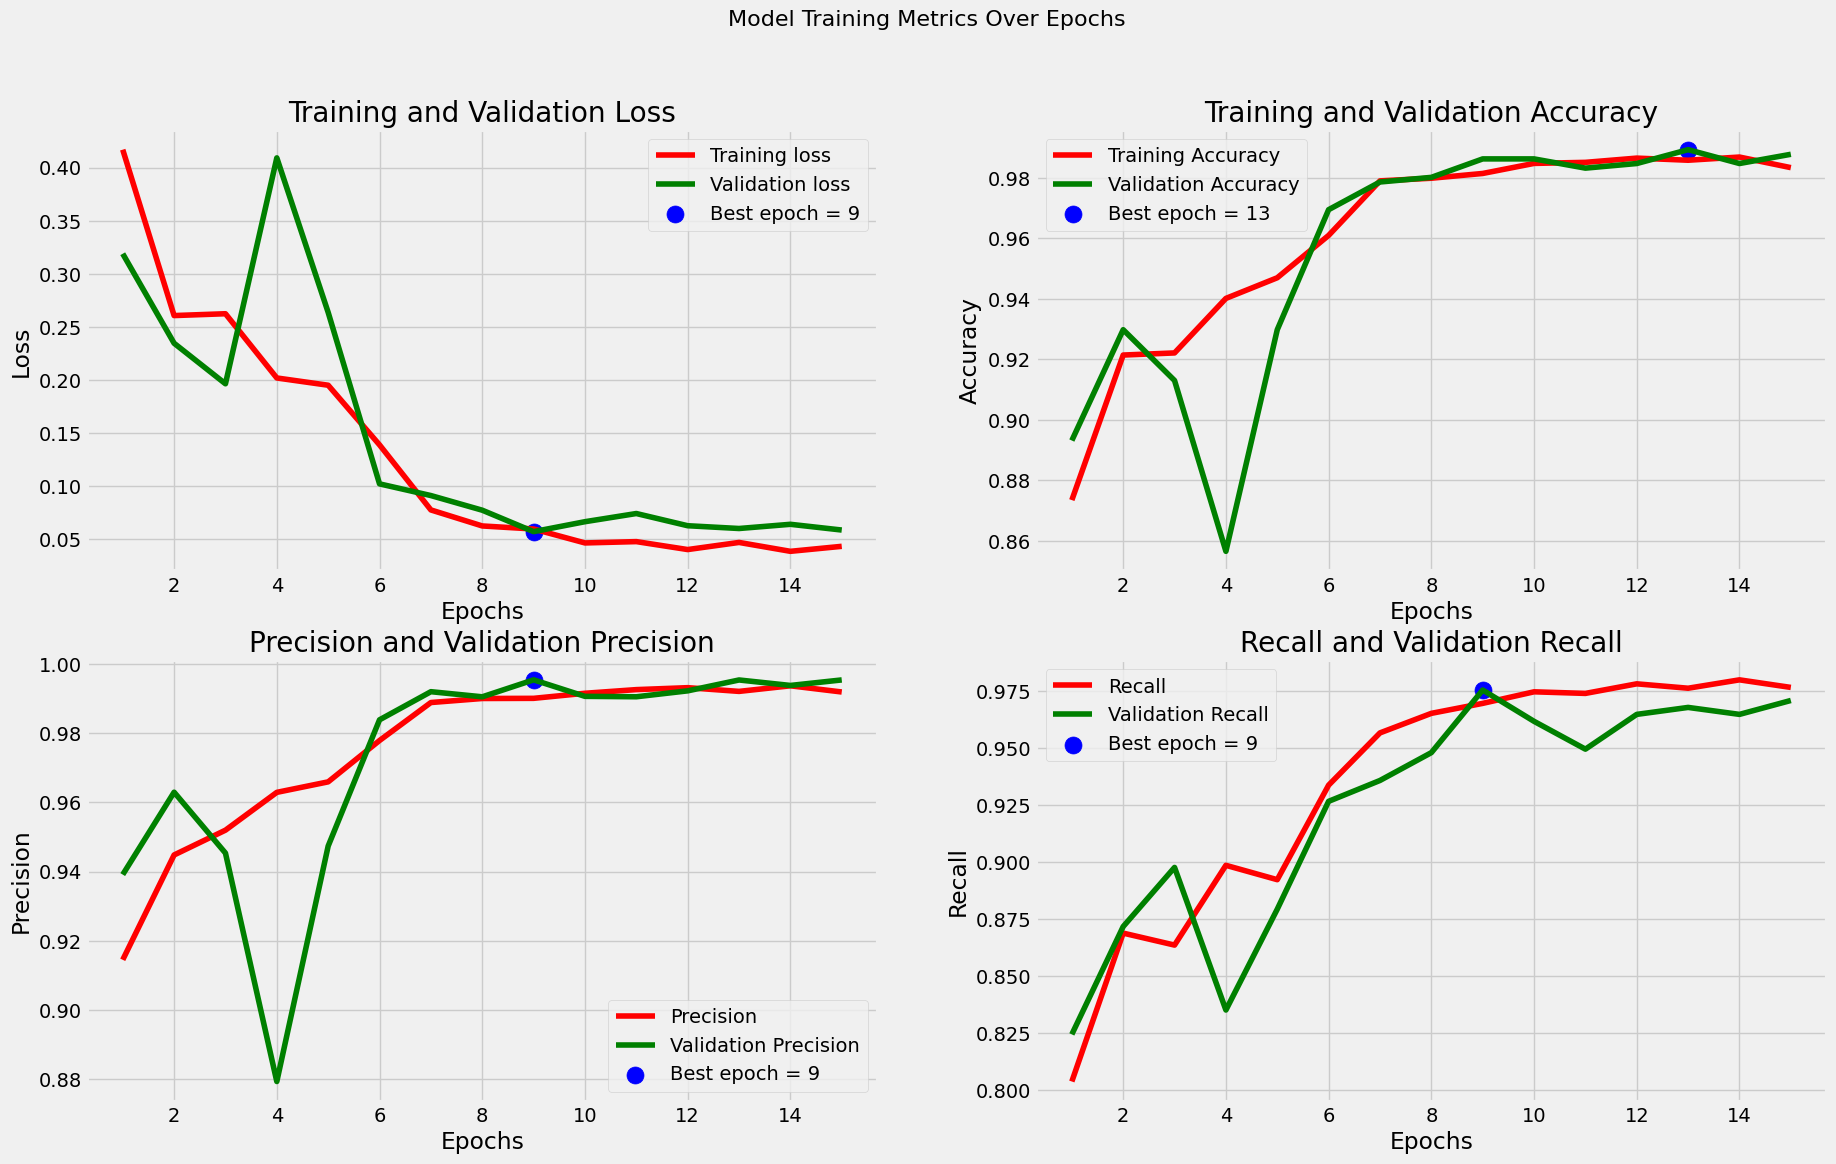

In [ ]:
tr_acc = hist4.history['accuracy']
tr_loss = hist4.history['loss']
tr_per = hist4.history['precision']
tr_recall = hist4.history['recall']
val_acc = hist4.history['val_accuracy']
val_loss = hist4.history['val_loss']
val_per = hist4.history['val_precision']
val_recall = hist4.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# Usar PdfPages para crear archivos PDF para cada gráfico
with PdfPages('training_validation_loss_4.pdf') as pdf:
    plt.figure(figsize=(10, 6))  # Tamaño ajustado
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Ajustar para mejor centrado
    pdf.savefig()  # Guardar la figura actual en el PDF
    plt.close()

with PdfPages('training_validation_accuracy_4.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

with PdfPages('training_validation_precision_4.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_per, 'r', label='Precision')
    plt.plot(Epochs, val_per, 'g', label='Validation Precision')
    plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

with PdfPages('training_validation_recall_4.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_recall, 'r', label='Recall')
    plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
    plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()


### Pruebas y Evaluación

### Evaluación

In [ ]:
train_score = model4.evaluate(tr_gen, verbose= 1)
valid_score = model4.evaluate(valid_gen, verbose= 1)
test_score = model4.evaluate(ts_gen, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

41/41 [==============================] - 10s 245ms/step - loss: 0.0697 - accuracy: 0.9695 - precision: 0.9827 - recall: 0.9543
Train Loss:  0.029255351051688194
Train Accuracy:  0.9959734082221985
--------------------
Validation Loss:  0.05876581743359566
Validation Accuracy:  0.9877862334251404
--------------------
Test Loss:  0.06969849765300751
Test Accuracy:  0.9695122241973877


In [ ]:
preds = model4.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 11s 264ms/step


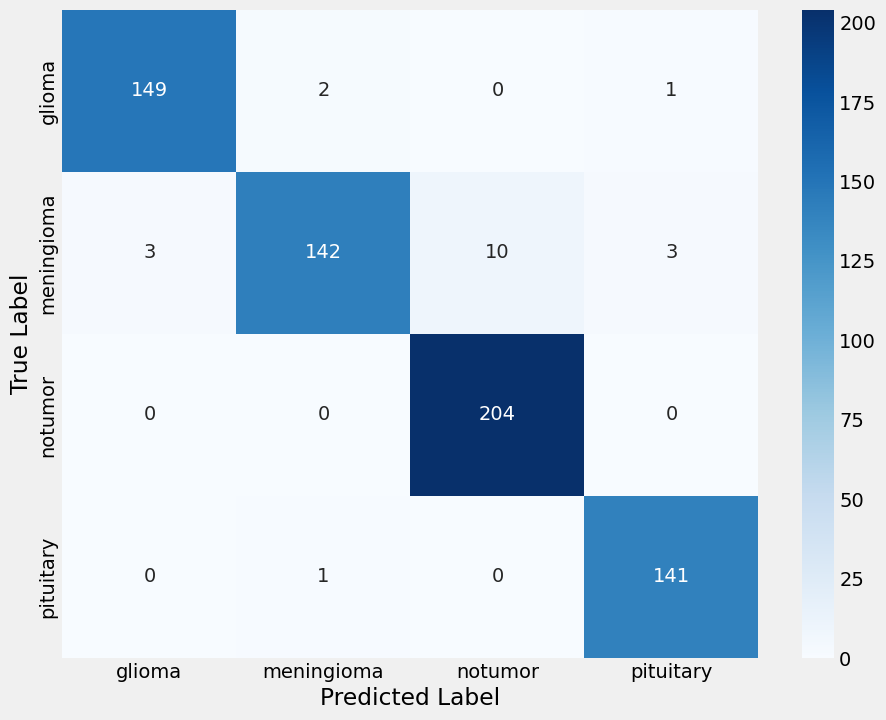

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Suponiendo que tienes las predicciones y las clases verdaderas
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Guardar la matriz de confusión en un archivo PDF
with PdfPages('confusion_matrix_4.pdf') as pdf:
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    pdf.savefig()  # Guarda el gráfico en el archivo PDF
    plt.close()


In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       152
           1       0.98      0.90      0.94       158
           2       0.95      1.00      0.98       204
           3       0.97      0.99      0.98       142

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



### Prueba

In [ ]:
def predict(img_path):
  import numpy as np
  import matplotlib.pyplot as plt
  from PIL import Image
  label = list(class_dict.keys())
  plt.figure(figsize=(12, 12))
  img = Image.open(img_path)
  resized_img = img.resize((224, 224))
  img = np.asarray(resized_img)
  img = np.expand_dims(img, axis=0)
  predictions = model4.predict(img)
  probs = list(predictions[0])
  labels = label
  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probs)
  plt.xlabel('Probability', fontsize=15)
  ax = plt.gca()
  ax.bar_label(bars, fmt = '%.2f')
  plt.show()

1/1 [==============================] - 0s 85ms/step


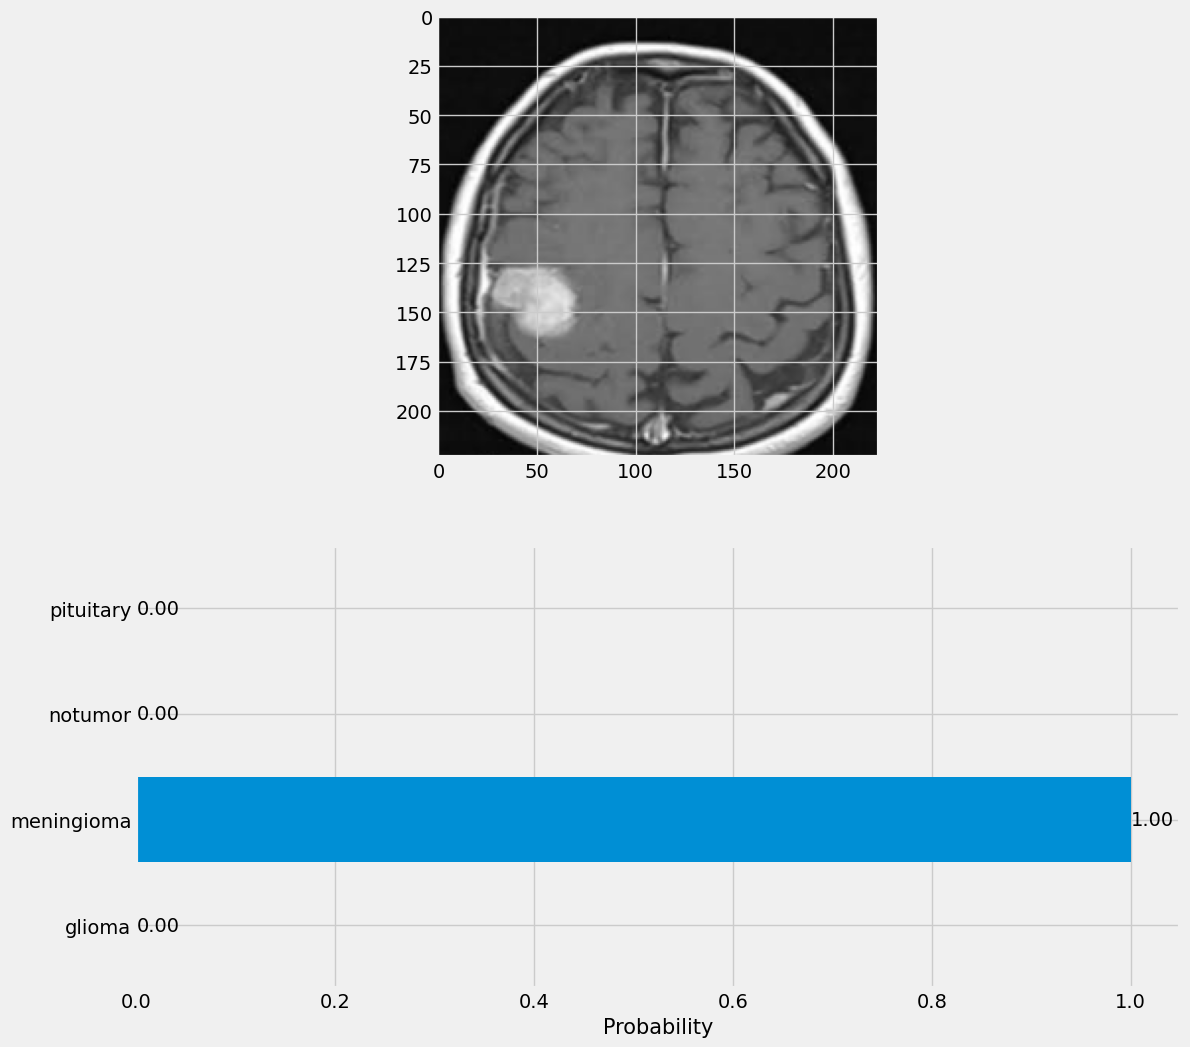

In [ ]:
predict("/content/drive/MyDrive/Tumor_Brain/Testing/meningioma/Te-me_0023.jpg")

1/1 [==============================] - 0s 82ms/step


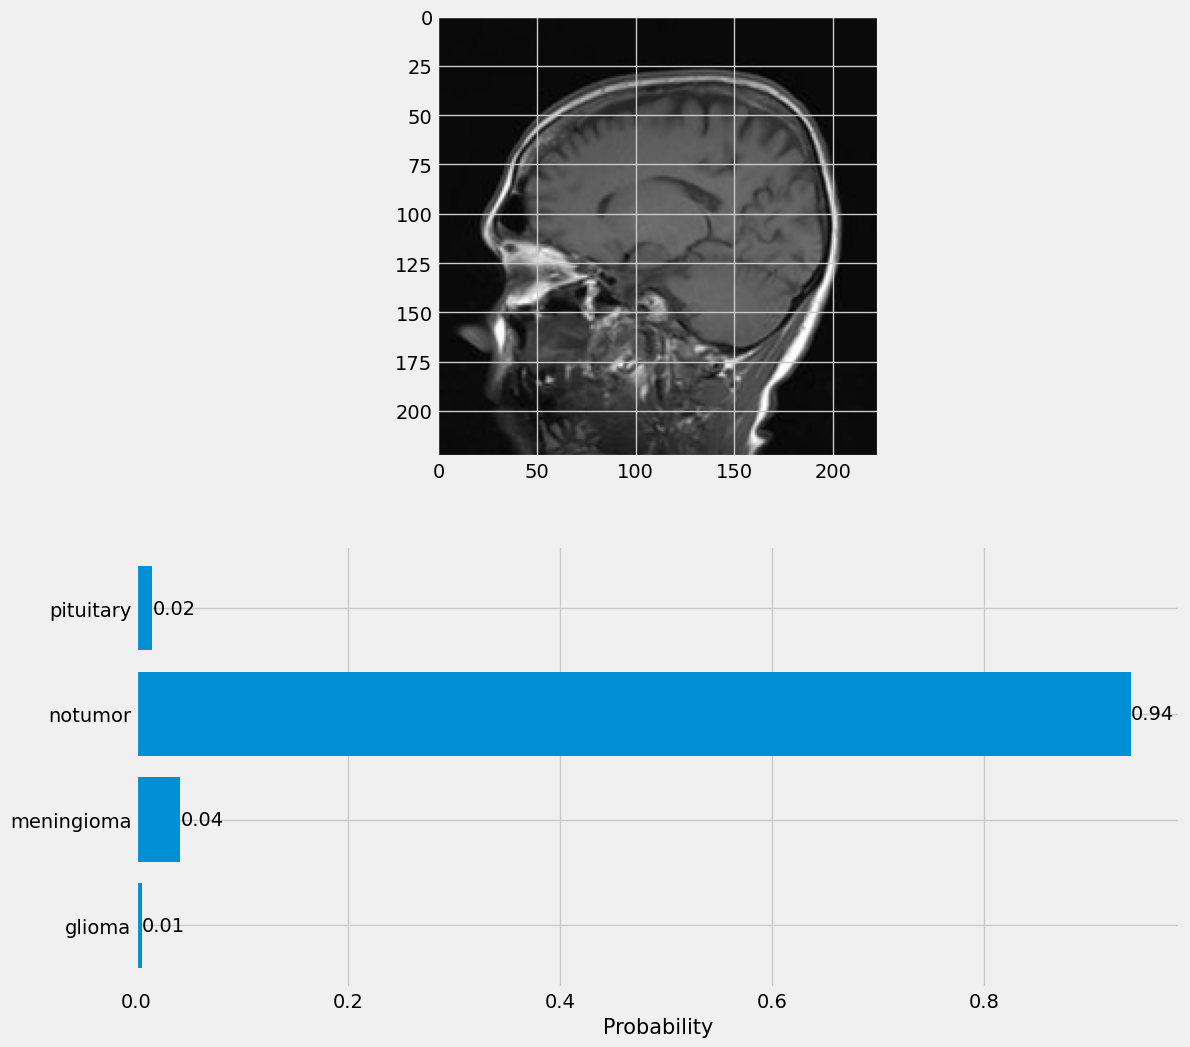

In [ ]:
predict("/content/drive/MyDrive/Tumor_Brain/Testing/notumor/Te-no_0015.jpg")

## Modelo 4: AdamW LearningRateScheduler




### Creación del Modelo de Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import LearningRateScheduler

precision_metric = Precision(name='precision')
recall_metric = Recall(name='recall')

# Definir la forma de entrada
img_shape = (224, 224, 3)

# Cargar el modelo preentrenado ResNet50
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet",
                                            input_shape=img_shape, pooling='max')

# Construir el modelo con una capa de entrada para definir la forma de entrada
input_tensor = tf.keras.Input(shape=img_shape)
x = base_model(input_tensor)
x = Flatten()(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.25)(x)
output_tensor = Dense(4, activation='softmax')(x)

# Crear el modelo
model5 = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# Compilar el modelo con el optimizador AdamW
model5.compile(AdamW(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       precision_metric,  # Métrica de Precisión
                       recall_metric])    # Métrica de Recall

# Mostrar el resumen del modelo
model5.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 23,797,380 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
tf.keras.utils.plot_model(model5, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Entrenamiento

In [ ]:

# Definir la función del scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  # Mantener la tasa de aprendizaje inicial durante las primeras 10 épocas
    else:
        return float(lr * tf.math.exp(-0.1))  # Reducir la tasa de aprendizaje exponencialmente después de la época 10

# Crear el callback del scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Entrenar el modelo con el LearningRateScheduler
hist5 = model5.fit(
    tr_gen,
    epochs=15,
    validation_data=valid_gen,
    shuffle=False,
    callbacks=[lr_scheduler]  # Añadir el callback del scheduler
)



Epoch 1/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.6600 - loss: 2.2793 - precision: 0.7096 - recall: 0.6020 - val_accuracy: 0.7420 - val_loss: 0.7241 - val_precision: 0.7996 - val_recall: 0.6885 - learning_rate: 0.0010
Epoch 2/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.8403 - loss: 0.4827 - precision: 0.8809 - recall: 0.7978 - val_accuracy: 0.5588 - val_loss: 1.1066 - val_precision: 0.5844 - val_recall: 0.5389 - learning_rate: 0.0010
Epoch 3/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.8526 - loss: 0.4392 - precision: 0.8926 - recall: 0.8129 - val_accuracy: 0.7985 - val_loss: 0.5846 - val_precision: 0.8099 - val_recall: 0.7740 - learning_rate: 0.0010
Epoch 4/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 463s 1s/step - accuracy: 0.9189 - loss: 0.2567 - precision: 0.9383 - recall: 0.9004 - val_accuracy: 0.8321 - val_loss: 0.7172 - val_precision: 0.8528 - val_recall: 0.8229 - learning_rate: 0.0010
Epoch 5/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accur

In [ ]:
hist5.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

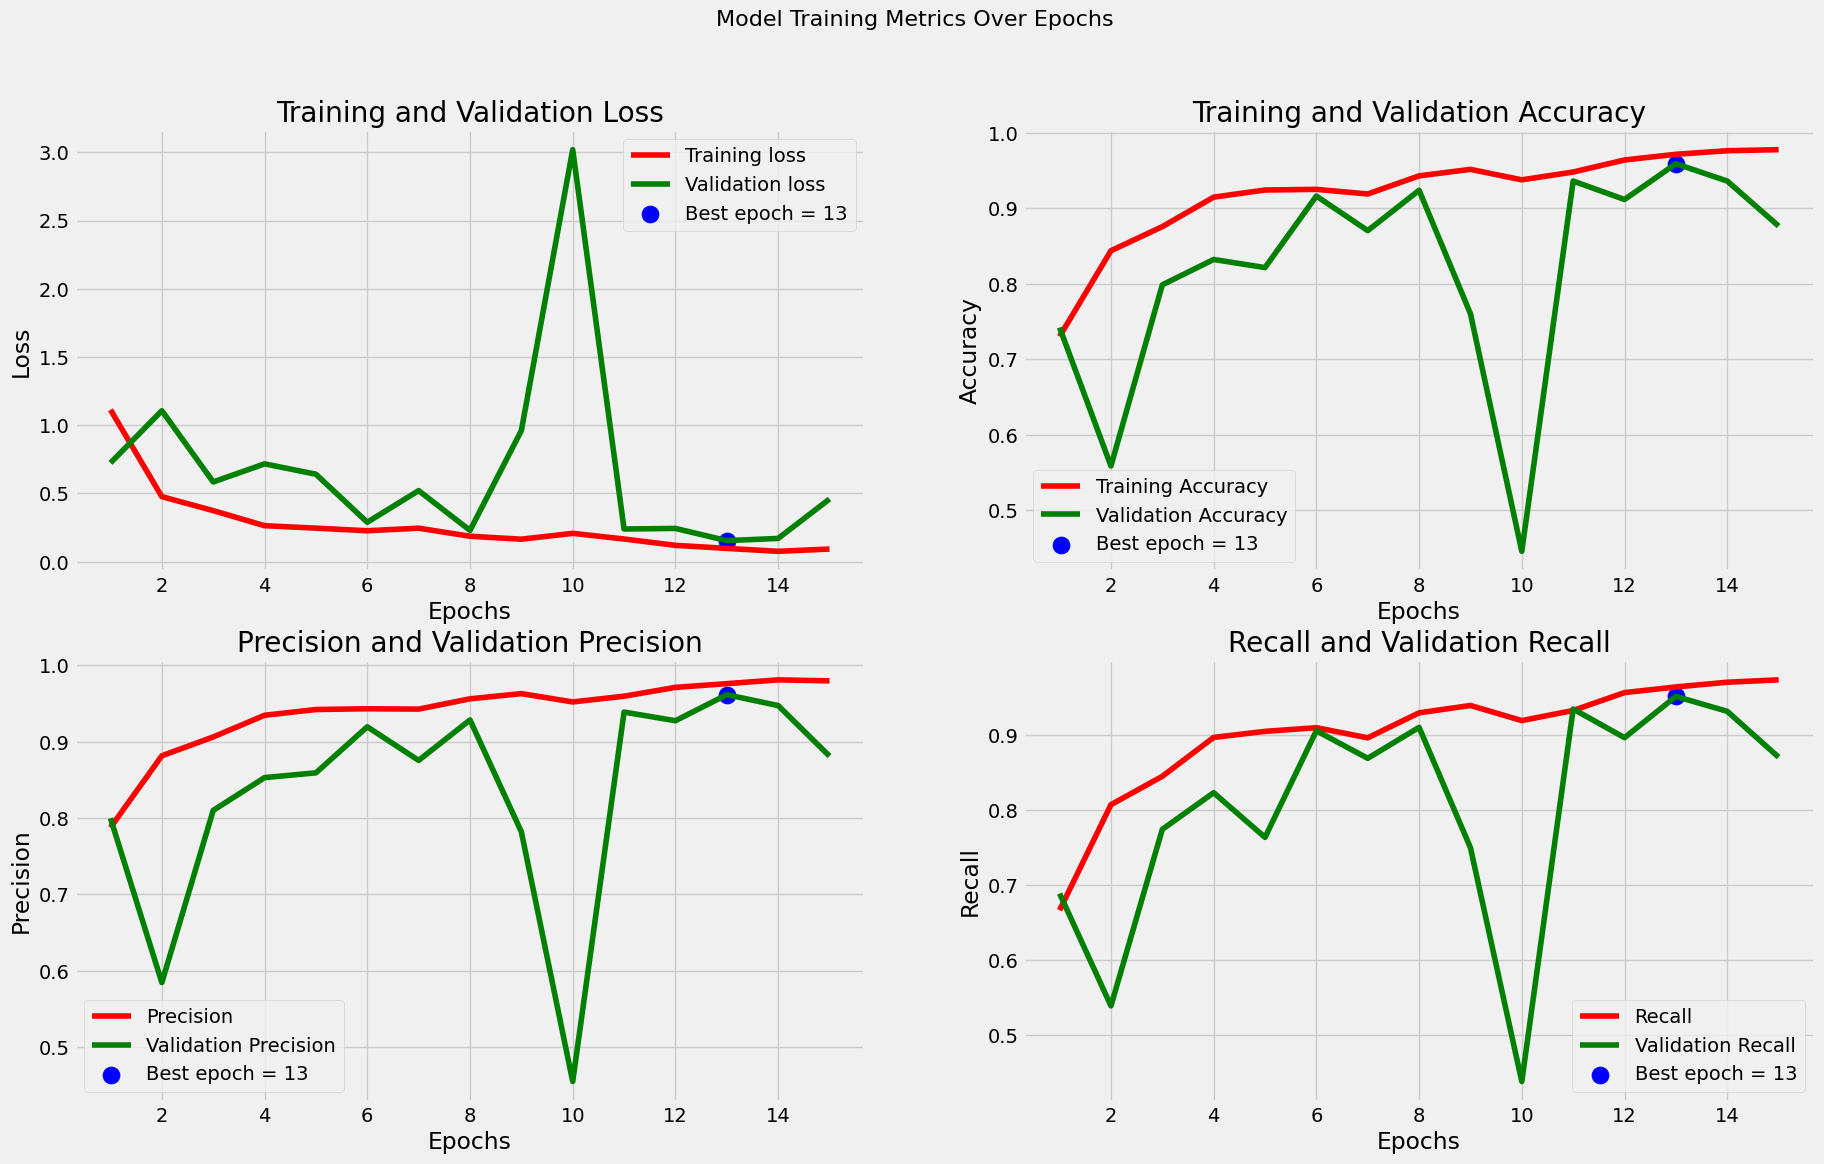

In [ ]:
tr_acc = hist5.history['accuracy']
tr_loss = hist5.history['loss']
tr_per = hist5.history['precision']
tr_recall = hist5.history['recall']
val_acc = hist5.history['val_accuracy']
val_loss = hist5.history['val_loss']
val_per = hist5.history['val_precision']
val_recall = hist5.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# Usar PdfPages para crear archivos PDF para cada gráfico
with PdfPages('training_validation_loss_5.pdf') as pdf:
    plt.figure(figsize=(10, 6))  # Tamaño ajustado
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Ajustar para mejor centrado
    pdf.savefig()  # Guardar la figura actual en el PDF
    plt.close()

with PdfPages('training_validation_accuracy_5.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

with PdfPages('training_validation_precision_5.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_per, 'r', label='Precision')
    plt.plot(Epochs, val_per, 'g', label='Validation Precision')
    plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

with PdfPages('training_validation_recall_5.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_recall, 'r', label='Recall')
    plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
    plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

### Pruebas y Evaluación

### Evaluación

In [ ]:
train_score = model5.evaluate(tr_gen, verbose= 1)
valid_score = model5.evaluate(valid_gen, verbose= 1)
test_score = model5.evaluate(ts_gen, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 86s 242ms/step - accuracy: 0.9168 - loss: 0.2394 - precision: 0.9212 - recall: 0.9121
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.8731 - loss: 0.4677 - precision: 0.8790 - recall: 0.8681
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.8546 - loss: 0.5237 - precision: 0.8552 - recall: 0.8511
Train Loss:  0.24648310244083405
Train Accuracy:  0.9163165092468262
--------------------
Validation Loss:  0.4594648778438568
Validation Accuracy:  0.876335859298706
--------------------
Test Loss:  0.4493733048439026
Test Accuracy:  0.8673780560493469


In [ ]:
preds = model5.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step


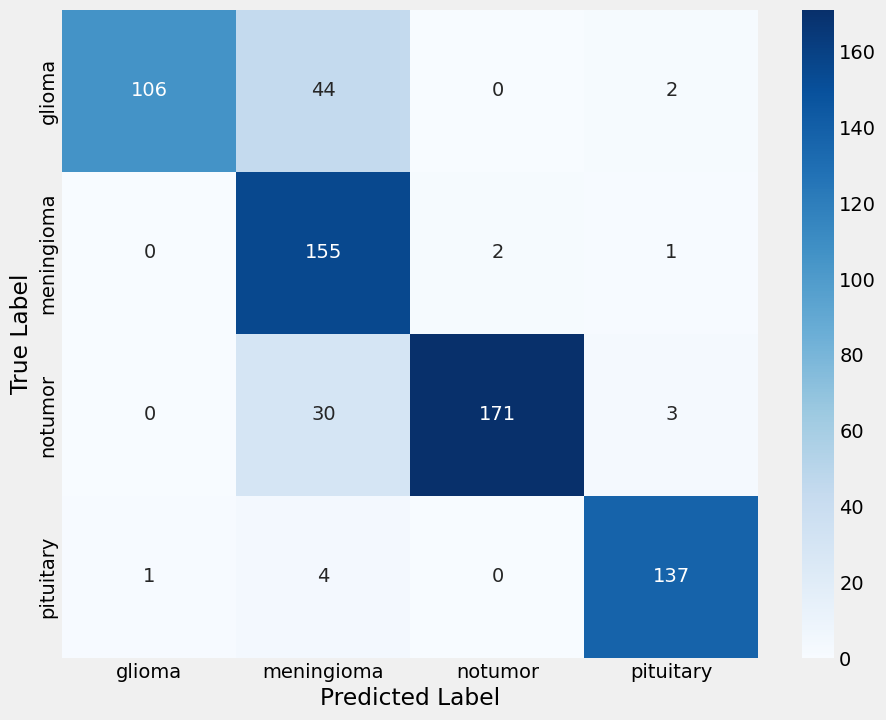

In [ ]:
# A partir de las predicciones (y_pred) y las clases verdaderas (ts_gen.classes)
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Guardar la matriz de confusión en un archivo PDF
with PdfPages('confusion_matrix_5.pdf') as pdf:
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    pdf.savefig()  # Guarda el gráfico en el archivo PDF
    plt.close()


In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       152
           1       0.67      0.98      0.79       158
           2       0.99      0.84      0.91       204
           3       0.96      0.96      0.96       142

    accuracy                           0.87       656
   macro avg       0.90      0.87      0.87       656
weighted avg       0.90      0.87      0.87       656



### Prueba

In [ ]:
def predict(img_path):
  import numpy as np
  import matplotlib.pyplot as plt
  from PIL import Image
  label = list(class_dict.keys())
  plt.figure(figsize=(12, 12))
  img = Image.open(img_path)
  resized_img = img.resize((224, 224))
  img = np.asarray(resized_img)
  img = np.expand_dims(img, axis=0)
  predictions = model5.predict(img)
  probs = list(predictions[0])
  labels = label
  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probs)
  plt.xlabel('Probability', fontsize=15)
  ax = plt.gca()
  ax.bar_label(bars, fmt = '%.2f')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


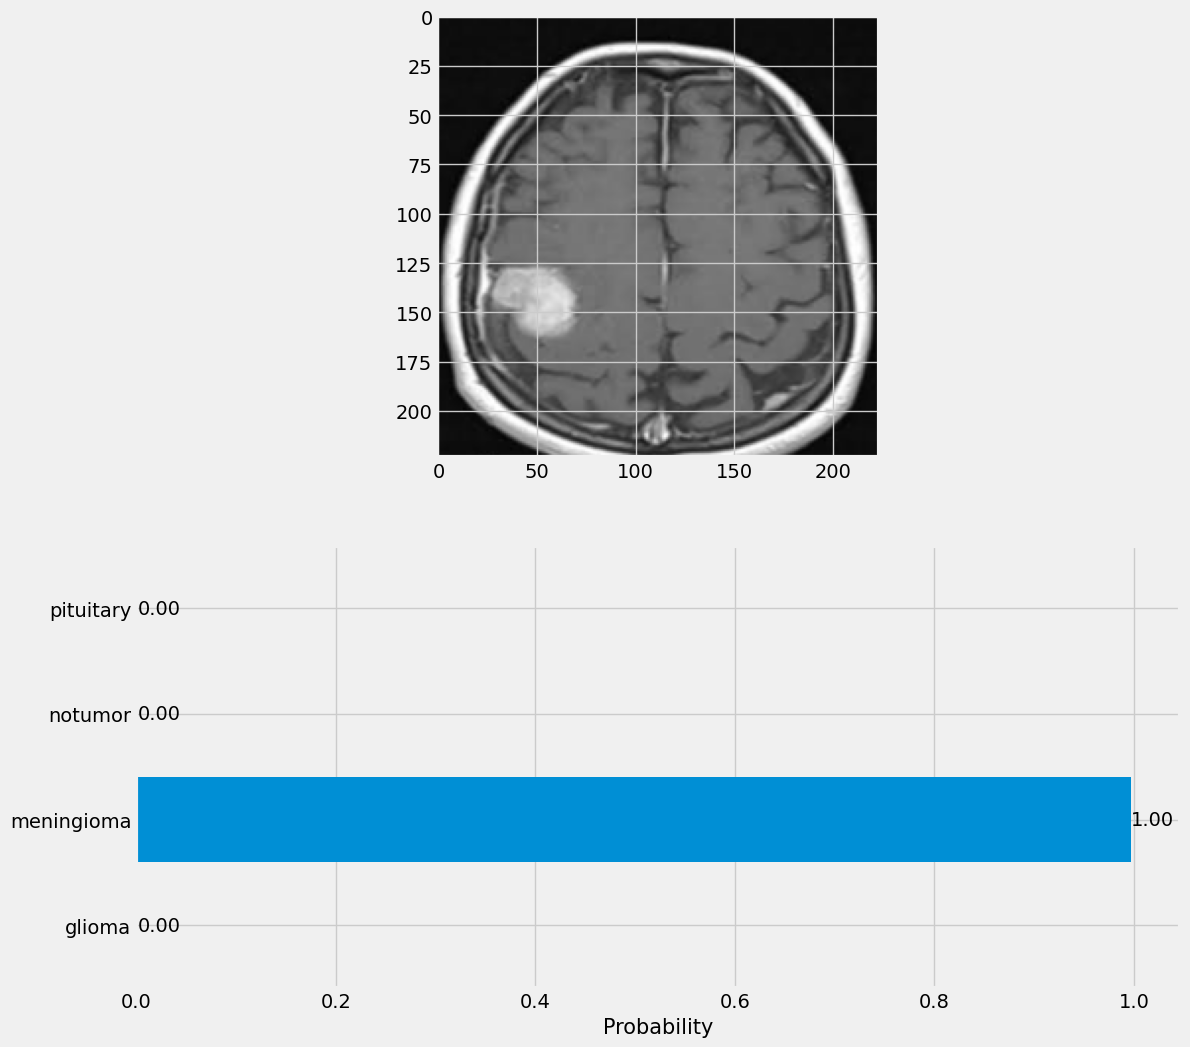

In [ ]:
predict("/content/drive/MyDrive/Tumor_Brain/Testing/meningioma/Te-me_0023.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


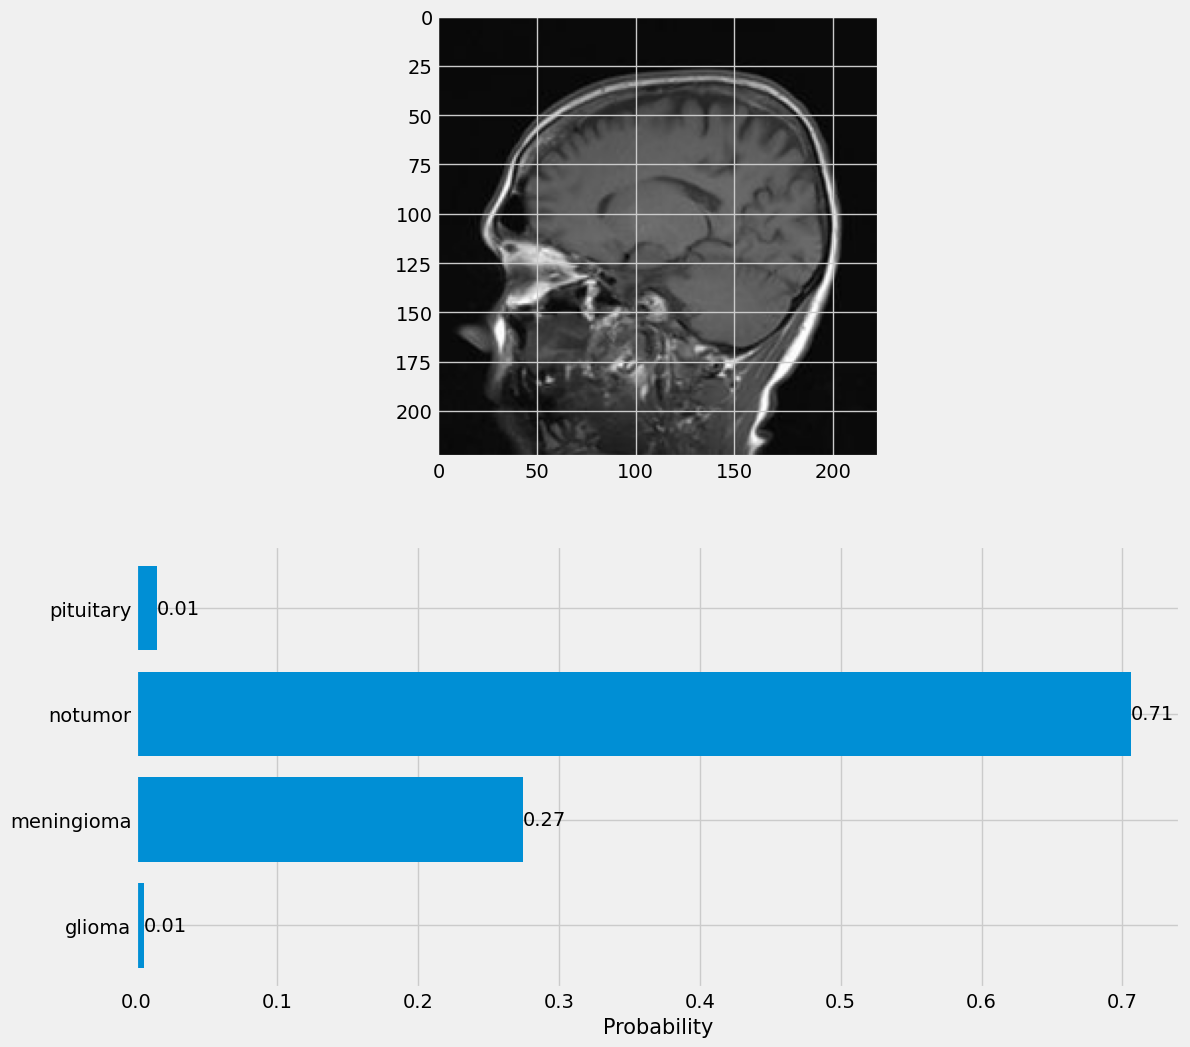

In [ ]:
predict("/content/drive/MyDrive/Tumor_Brain/Testing/notumor/Te-no_0015.jpg")

## Preprocesamiento CLAHE

In [ ]:
tr_gen_clahe = ImageDataGenerator(brightness_range=(.8,1.2))

In [ ]:
gen_clahe = ImageDataGenerator()

### Flujo de imágenes de entrenamiento

In [ ]:
import os
import cv2
import pandas as pd

def apply_clahe(image_path):
    # Lee la imagen en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Verifica si la imagen se ha cargado correctamente
    if image is None:
        raise ValueError(f"Error al leer la imagen: {image_path}")

    # Crear un objeto CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Aplicar CLAHE a la imagen
    clahe_image = clahe.apply(image)

    return clahe_image

def save_image(image, path):
    # Guarda la imagen en el disco
    cv2.imwrite(path, image)


def test_df_clahe(ts_path, output_path):
    # Se inicializan dos listas vacías: classes para almacenar las etiquetas de
    # las clases y class_paths para almacenar las rutas completas de las imágenes.
    classes = []
    class_paths = []

    # Variable para obtener una lista de los nombres de las subcarpetas en el
    # directorio ts_path. Cada subcarpeta se asume que representa una clase diferente.
    files = os.listdir(ts_path)

    # Iteración a través de las Subcarpetas y Archivos
    for file in files:
        # Ruta completa a la subcarpeta.
        label_dir = os.path.join(ts_path, file)

        # Lista de todos los archivos (imágenes) en la subcarpeta.
        label = os.listdir(label_dir)

        # Crear un directorio para las imágenes procesadas si no existe
        processed_dir = os.path.join(output_path, file)
        os.makedirs(processed_dir, exist_ok=True)

        # Se itera sobre cada archivo de imagen en label.
        for image in label:
            # Ruta completa a la imagen.
            image_path = os.path.join(label_dir, image)

            # Aplica CLAHE a la imagen
            clahe_image = apply_clahe(image_path)

            # Ruta para guardar la imagen procesada
            processed_image_path = os.path.join(processed_dir, image)

            # Guarda la imagen procesada
            save_image(clahe_image, processed_image_path)

            # Añade la ruta de la imagen procesada a la lista class_paths.
            class_paths.append(processed_image_path)

            # Añade la etiqueta de la clase (nombre de la subcarpeta) a la lista classes.
            classes.append(file)

    # Se crea una Serie de Pandas con las etiquetas de clase, nombrada 'Class'.
    image_classes = pd.Series(classes, name='Class')

    # Se crea una Serie de Pandas con las rutas de las imágenes procesadas, nombrada 'Class Path'.
    image_paths = pd.Series(class_paths, name='Class Path')

    # Combina las dos Series en un DataFrame de Pandas a lo largo del eje de columnas (axis=1).
    ts_df_clahe = pd.concat([image_paths, image_classes], axis=1)

    # Se devuelve el DataFrame resultante.
    return ts_df_clahe



In [ ]:
def train_df_clahe(tr_path, output_path):
    # Se inicializan dos listas vacías: classes para almacenar las etiquetas de
    # las clases y class_paths para almacenar las rutas completas de las imágenes.
    classes = []
    class_paths = []

    # Variable para obtener una lista de los nombres de las subcarpetas en el
    # directorio tr_path. Cada subcarpeta se asume que representa una clase diferente.
    files = os.listdir(tr_path)

    # Iteración a través de las Subcarpetas y Archivos
    for file in files:
        # Ruta completa a la subcarpeta.
        label_dir = os.path.join(tr_path, file)

        # Lista de todos los archivos (imágenes) en la subcarpeta.
        label = os.listdir(label_dir)

        # Crear un directorio para las imágenes procesadas si no existe
        processed_dir = os.path.join(output_path, file)
        os.makedirs(processed_dir, exist_ok=True)

        # Se itera sobre cada archivo de imagen en label.
        for image in label:
            # Ruta completa a la imagen.
            image_path = os.path.join(label_dir, image)

            # Aplica CLAHE a la imagen
            clahe_image = apply_clahe(image_path)

            # Ruta para guardar la imagen procesada
            processed_image_path = os.path.join(processed_dir, image)

            # Guarda la imagen procesada
            save_image(clahe_image, processed_image_path)

            # Añade la ruta de la imagen procesada a la lista class_paths.
            class_paths.append(processed_image_path)

            # Añade la etiqueta de la clase (nombre de la subcarpeta) a la lista classes.
            classes.append(file)

    # Se crea una Serie de Pandas con las etiquetas de clase, nombrada 'Class'.
    image_classes = pd.Series(classes, name='Class')

    # Se crea una Serie de Pandas con las rutas de las imágenes procesadas, nombrada 'Class Path'.
    image_paths = pd.Series(class_paths, name='Class Path')

    # Combina las dos Series en un DataFrame de Pandas a lo largo del eje de columnas (axis=1).
    tr_df_clahe = pd.concat([image_paths, image_classes], axis=1)

    # Se devuelve el DataFrame resultante.
    return tr_df_clahe




In [ ]:
# La variable tr_df se obtiene de la función train_df utilizando la ruta
# /content/drive/MyDrive/Tumor_Brain/Training

tr_df_clahe = train_df_clahe("/content/drive/MyDrive/Tumor_Brain/Training","/content/drive/MyDrive/Tumor_Brain_CLAHE/Training")

In [ ]:
print(f"El dataframe de entranemiento tiene {tr_df_clahe.shape[0]} filas y {tr_df_clahe.shape[1]} columnas")

El dataframe de entranemiento tiene 5712 filas y 2 columnas


In [ ]:
# La variable ts_df se obtiene de la función train_df utilizando la ruta
# /content/drive/MyDrive/Tumor_Brain/Testing

ts_df_clahe = test_df_clahe('/content/drive/MyDrive/Tumor_Brain/Testing', '/content/drive/MyDrive/Tumor_Brain_CLAHE/Testing')

In [ ]:
print(f"El dataframe de entranemiento tiene {ts_df.shape[0]} filas y {ts_df.shape[1]} columnas")

El dataframe de entranemiento tiene 1311 filas y 2 columnas


## División de los datos en entrenamiento, prueba y validación

In [ ]:
# El dataset de validación se obtiene diviendo la mitad del dataset de test

valid_df_clahe, ts_df_clahe = train_test_split(ts_df_clahe, train_size=.5, random_state=20)

In [ ]:
print(f"El dataframe de entranemiento tiene {valid_df_clahe.shape[0]} filas y {valid_df_clahe.shape[1]} columnas")

El dataframe de entranemiento tiene 655 filas y 2 columnas


## Preprocesamiento de Datos

In [ ]:
tr_gen_clahe = ImageDataGenerator(brightness_range=(.8,1.2))

In [ ]:
gen_clahe = ImageDataGenerator()

### Flujo de imágenes de entrenamiento

In [ ]:
tr_gen_clahe = tr_gen_clahe.flow_from_dataframe(tr_df_clahe, x_col='Class Path',
y_col='Class',batch_size=batch_size,
target_size=img_size)

Found 5712 validated image filenames belonging to 4 classes.


### Flujo de imágenes de validación

In [ ]:
valid_gen_clahe = gen_clahe.flow_from_dataframe(valid_df_clahe, x_col='Class Path',
y_col='Class',batch_size=batch_size,
target_size=img_size)

Found 655 validated image filenames belonging to 4 classes.


### Flujo de imágenes de prueba

In [ ]:
ts_gen_clahe = gen_clahe.flow_from_dataframe(ts_df_clahe, x_col='Class Path',
y_col='Class',batch_size=batch_size,
target_size=img_size,shuffle=False)

Found 656 validated image filenames belonging to 4 classes.


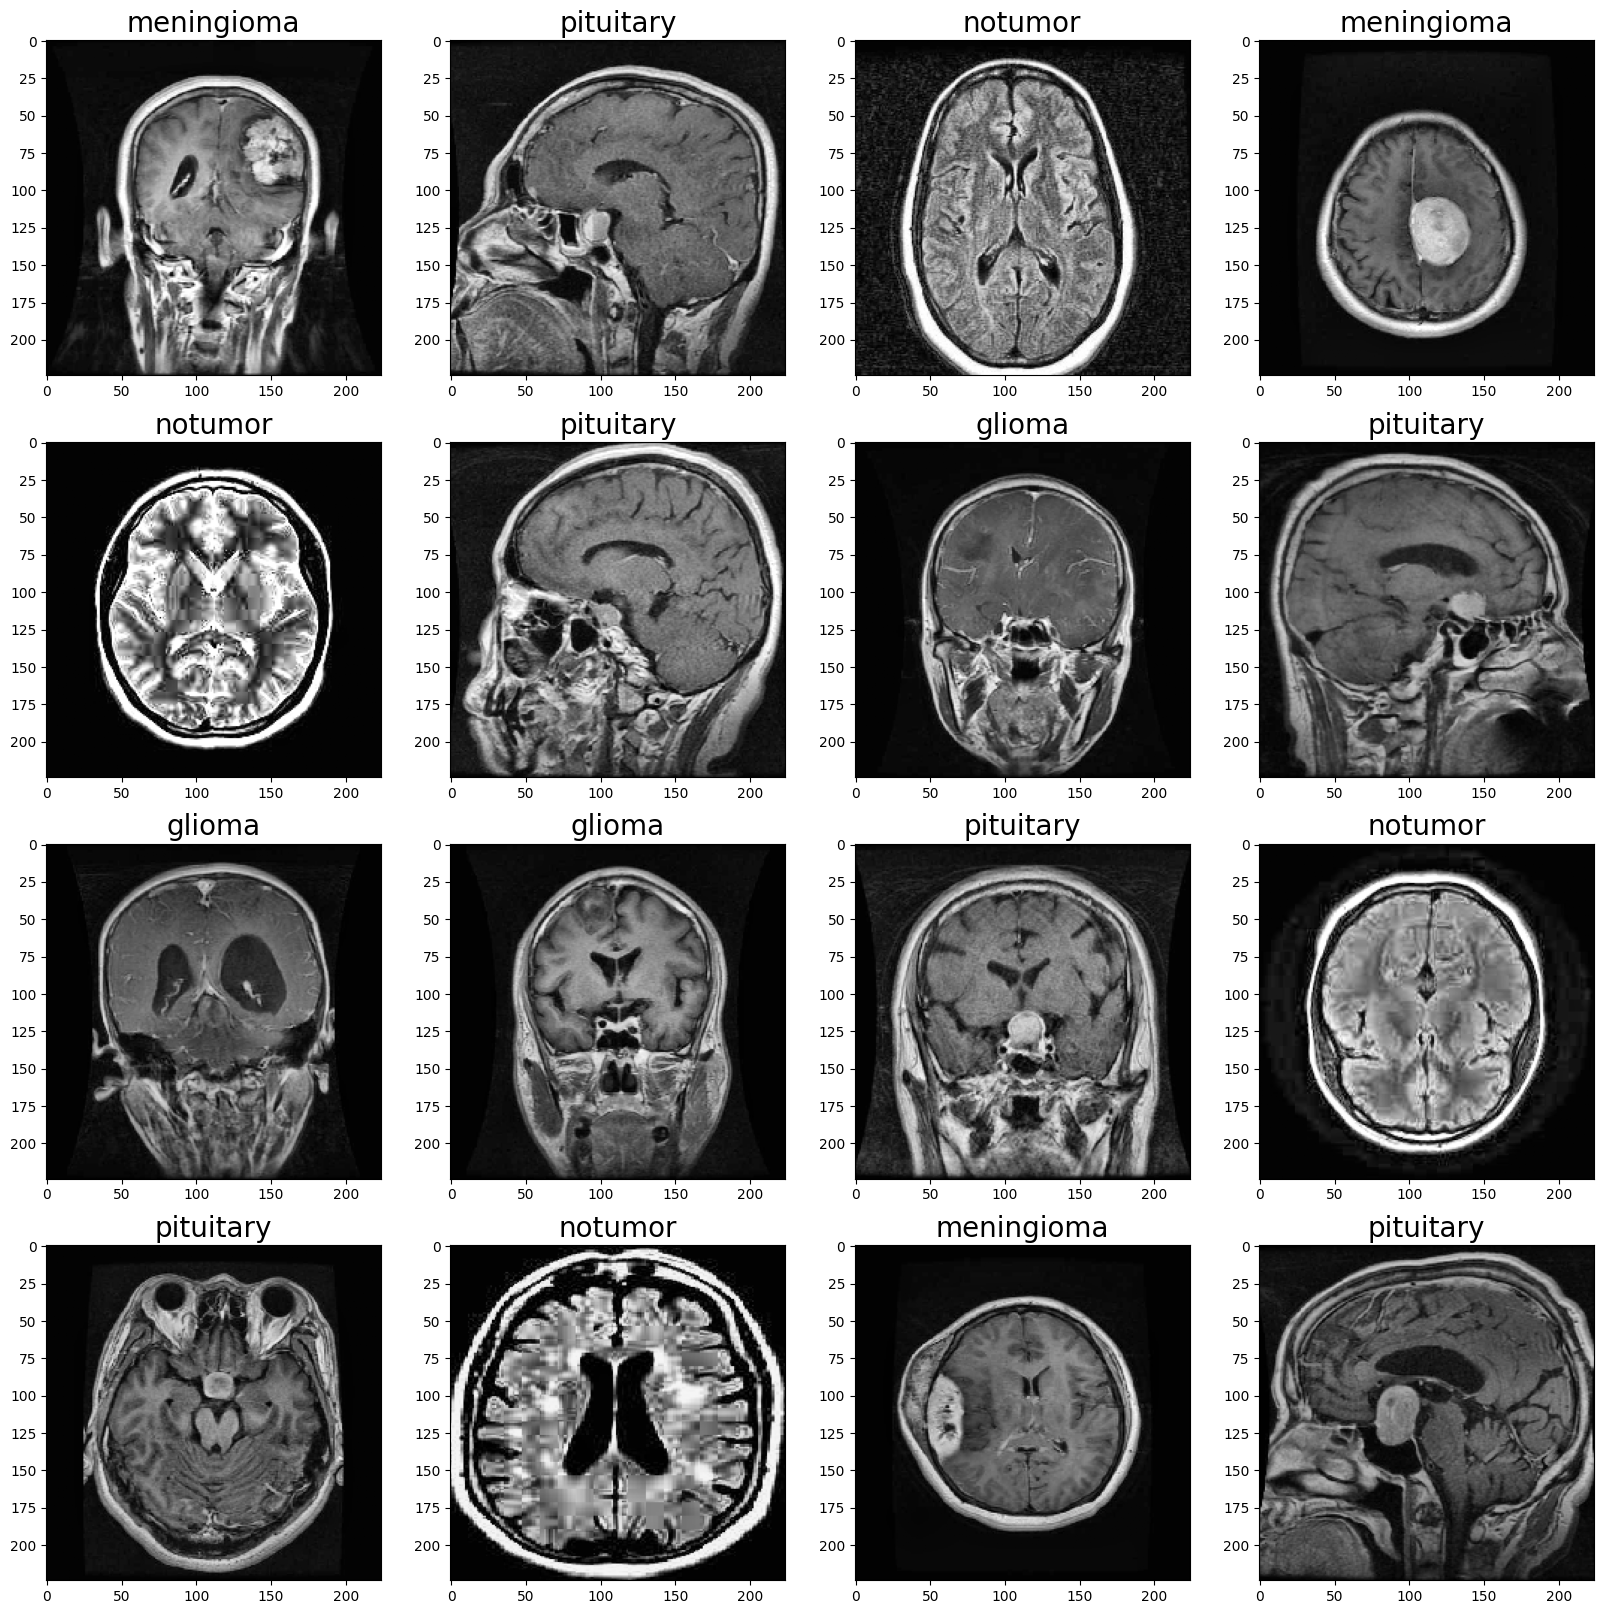

In [ ]:
class_dict = tr_gen_clahe.class_indices
classes = list(class_dict.keys())
images, labels = next(tr_gen_clahe)
plt.figure(figsize= (20, 20))
for i in range(16):
  plt.subplot(4,4,i+1)
  image = images[i] / 255
  plt.imshow(image)
  index = np.argmax(labels[i])
  class_name = classes[index]
  plt.title(class_name, color='k', fontsize=20)
plt.show()

## Modelo 3 con el dataset luego de aplicar CLAHE

### Creación del Modelo de Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

precision_metric = Precision(name='precision')
recall_metric = Recall(name='recall')

# Definir la forma de entrada
img_shape = (224, 224, 3)

# Cargar el modelo preentrenado ResNet50
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet",
                                            input_shape=img_shape, pooling='max')

# Construir el modelo con una capa de entrada para definir la forma de entrada
input_tensor = tf.keras.Input(shape=img_shape)
x = base_model(input_tensor)
x = Flatten()(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.25)(x)
output_tensor = Dense(4, activation='softmax')(x)

# Crear el modelo
model3c = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)

# Compilar el modelo con el optimizador SGD con momentum 0.95
model3c.compile(SGD(learning_rate=0.001, momentum=0.95),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       precision_metric,
                       recall_metric])

# Mostrar el resumen del modelo
model3c.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 23,797,380 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
tf.keras.utils.plot_model(model3c, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Entrenamiento

In [ ]:

# Definir la función del scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)  # Mantener la tasa de aprendizaje inicial durante las primeras 10 épocas
    else:
        return float(lr * tf.math.exp(-0.1))  # Reducir la tasa de aprendizaje exponencialmente después de la época 10

# Crear el callback del scheduler
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Entrenar el modelo con el LearningRateScheduler
hist3c = model3c.fit(
    tr_gen_clahe,
    epochs=15,
    validation_data=valid_gen_clahe,
    shuffle=False,
    callbacks=[lr_scheduler]  # Añadir el callback del scheduler
)



Epoch 1/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 490s 1s/step - accuracy: 0.5800 - loss: 2.6133 - precision: 0.7093 - recall: 0.4230 - val_accuracy: 0.7985 - val_loss: 0.5794 - val_precision: 0.8693 - val_recall: 0.6702 - learning_rate: 0.0010
Epoch 2/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.7780 - loss: 0.6384 - precision: 0.9150 - recall: 0.5757 - val_accuracy: 0.8290 - val_loss: 0.5755 - val_precision: 0.9264 - val_recall: 0.6534 - learning_rate: 0.0010
Epoch 3/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.7709 - loss: 0.6328 - precision: 0.9532 - recall: 0.5548 - val_accuracy: 0.7710 - val_loss: 0.5967 - val_precision: 0.7993 - val_recall: 0.7237 - learning_rate: 0.0010
Epoch 4/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.8242 - loss: 0.4851 - precision: 0.8345 - recall: 0.8042 - val_accuracy: 0.8947 - val_loss: 0.4122 - val_precision: 0.9017 - val_recall: 0.8824 - learning_rate: 0.0010
Epoch 5/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - accur

In [ ]:
hist3c.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

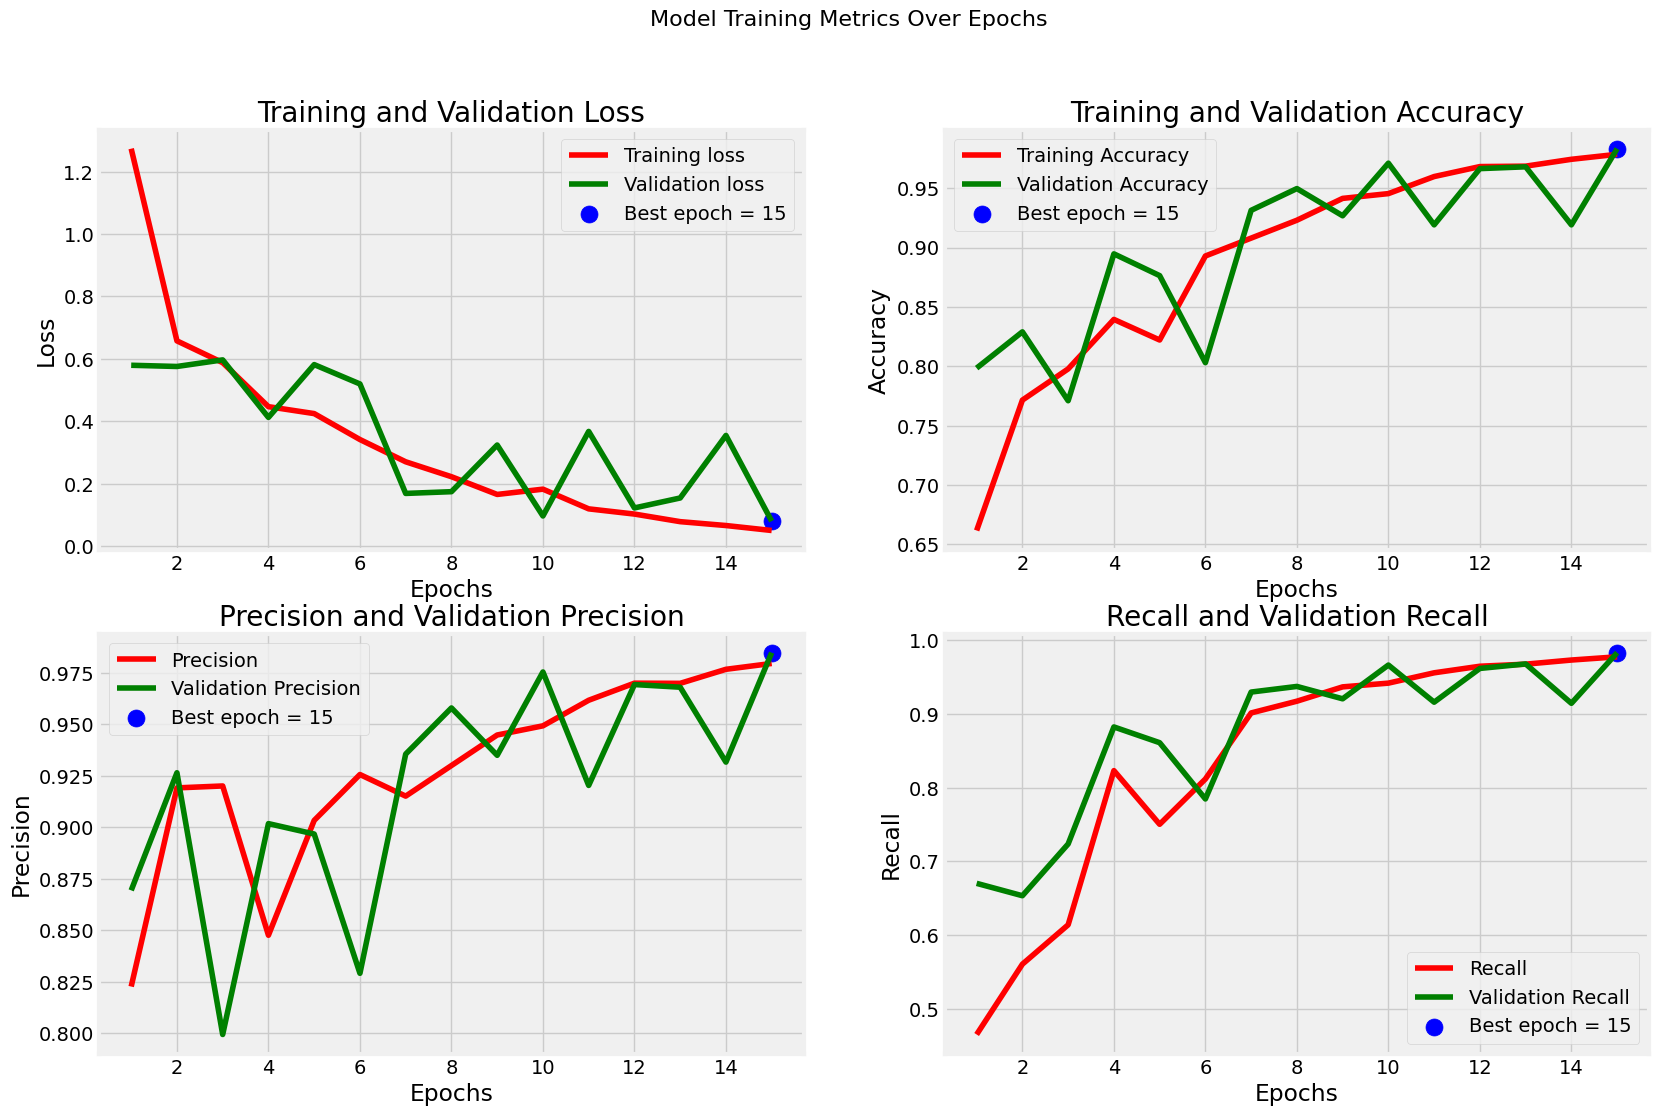

In [ ]:
tr_acc = hist3c.history['accuracy']
tr_loss = hist3c.history['loss']
tr_per = hist3c.history['precision']
tr_recall = hist3c.history['recall']
val_acc = hist3c.history['val_accuracy']
val_loss = hist3c.history['val_loss']
val_per = hist3c.history['val_precision']
val_recall = hist3c.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# Usar PdfPages para crear archivos PDF para cada gráfico
with PdfPages('training_validation_loss_3c.pdf') as pdf:
    plt.figure(figsize=(10, 6))  # Tamaño ajustado
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Ajustar para mejor centrado
    pdf.savefig()  # Guardar la figura actual en el PDF
    plt.close()

with PdfPages('training_validation_accuracy_3c.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

with PdfPages('training_validation_precision_3c.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_per, 'r', label='Precision')
    plt.plot(Epochs, val_per, 'g', label='Validation Precision')
    plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

with PdfPages('training_validation_recall_3c.pdf') as pdf:
    plt.figure(figsize=(10, 6))
    plt.plot(Epochs, tr_recall, 'r', label='Recall')
    plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
    plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
    plt.title('Training and Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    pdf.savefig()
    plt.close()

### Pruebas y Evaluación

### Evaluación

In [ ]:
train_score = model3c.evaluate(tr_gen_clahe, verbose= 1)
valid_score = model3c.evaluate(valid_gen_clahe, verbose= 1)
test_score = model3c.evaluate(ts_gen_clahe, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 80s 224ms/step - accuracy: 0.9993 - loss: 0.0031 - precision: 0.9993 - recall: 0.9992
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.9888 - loss: 0.0558 - precision: 0.9905 - recall: 0.9888
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.9802 - loss: 0.0776 - precision: 0.9874 - recall: 0.9777
Train Loss:  0.005938439164310694
Train Accuracy:  0.9985994100570679
--------------------
Validation Loss:  0.07965369522571564
Validation Accuracy:  0.9832060933113098
--------------------
Test Loss:  0.08937820792198181
Test Accuracy:  0.9786585569381714


In [ ]:
preds = model3c.predict(ts_gen_clahe)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step


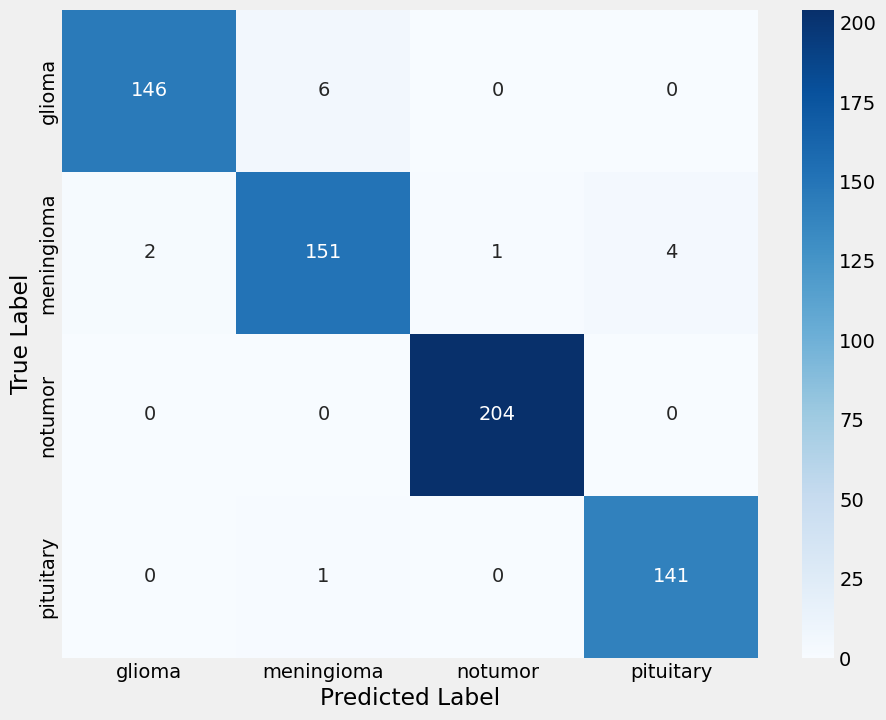

In [ ]:
# A partir de las predicciones (y_pred) y las clases verdaderas (ts_gen.classes)
cm = confusion_matrix(ts_gen_clahe.classes, y_pred)
labels = list(class_dict.keys())

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Guardar la matriz de confusión en un archivo PDF
with PdfPages('confusion_matrix_3c.pdf') as pdf:
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    pdf.savefig()  # Guarda el gráfico en el archivo PDF
    plt.close()


In [ ]:
clr = classification_report(ts_gen_clahe.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       152
           1       0.96      0.96      0.96       158
           2       1.00      1.00      1.00       204
           3       0.97      0.99      0.98       142

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



### Prueba

In [ ]:
def predict(img_path):
  import numpy as np
  import matplotlib.pyplot as plt
  from PIL import Image
  label = list(class_dict.keys())
  plt.figure(figsize=(12, 12))
  img = Image.open(img_path)
  resized_img = img.resize((224, 224))
  img = np.asarray(resized_img)
  img = np.expand_dims(img, axis=0)
  predictions = model3c.predict(img)
  probs = list(predictions[0])
  labels = label
  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probs)
  plt.xlabel('Probability', fontsize=15)
  ax = plt.gca()
  ax.bar_label(bars, fmt = '%.2f')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


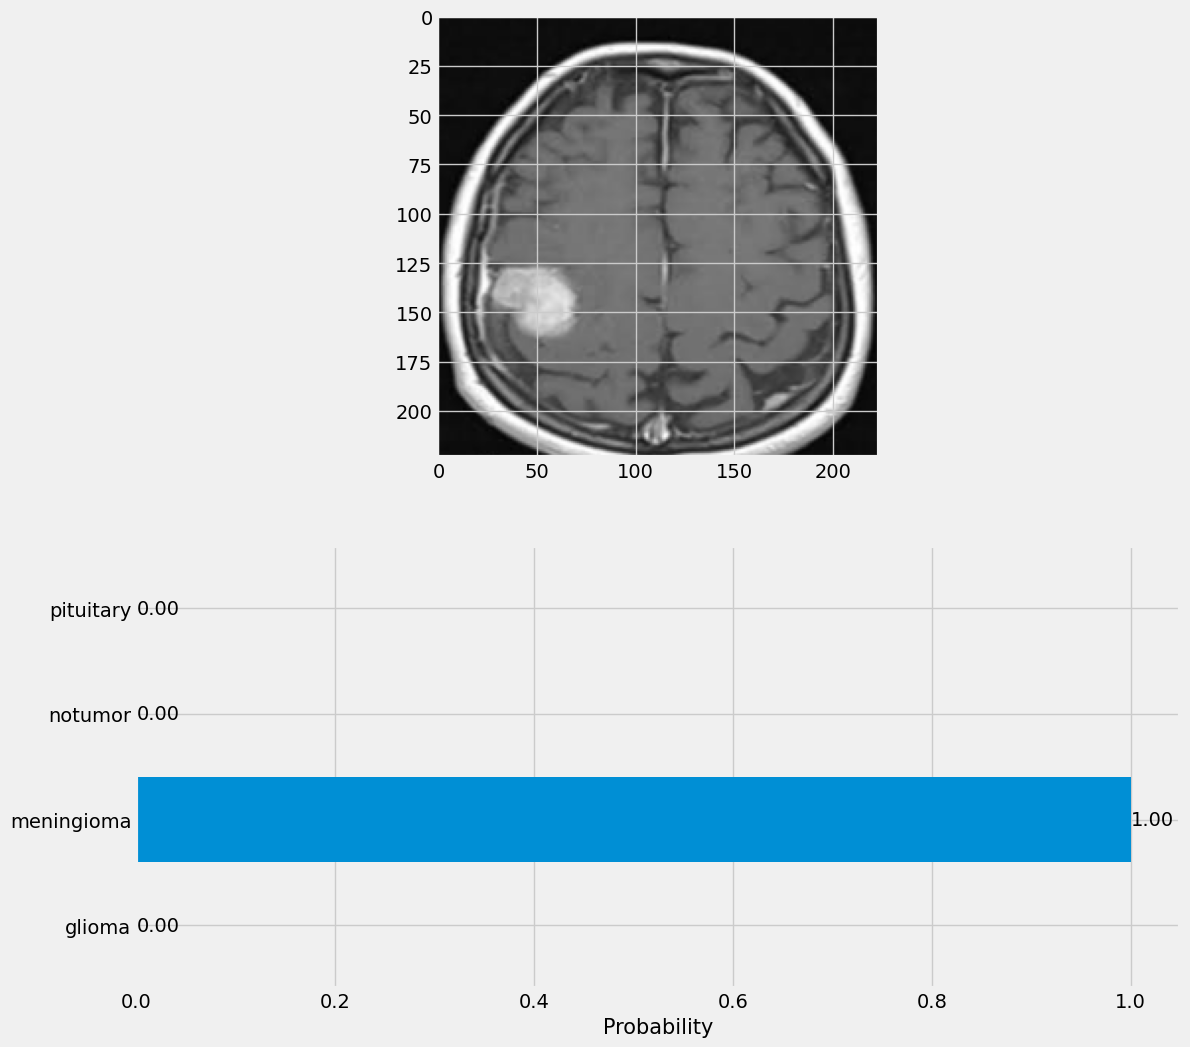

In [ ]:
predict("/content/drive/MyDrive/Tumor_Brain/Testing/meningioma/Te-me_0023.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


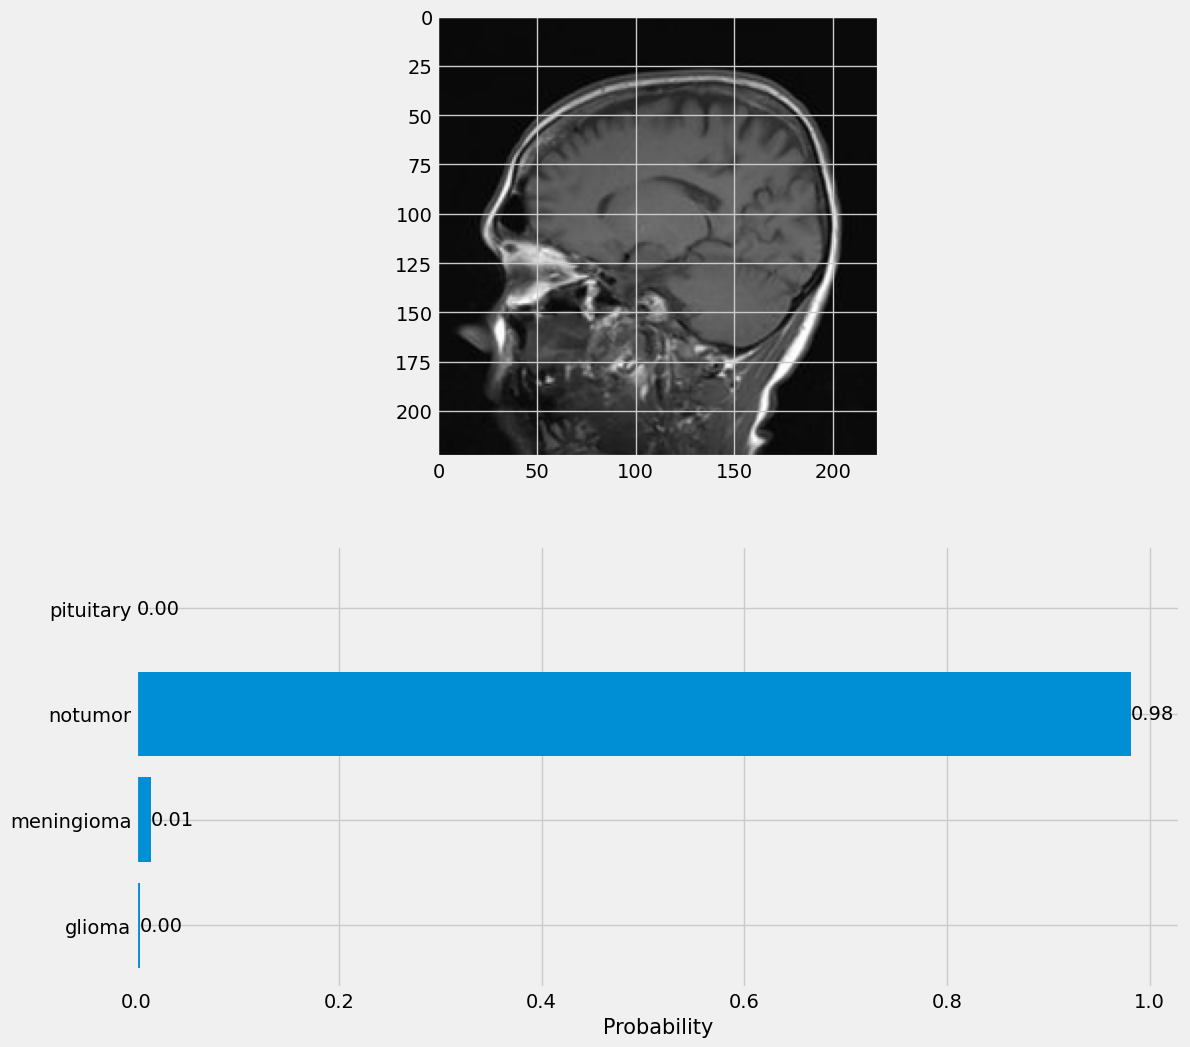

In [ ]:
predict("/content/drive/MyDrive/Tumor_Brain/Testing/notumor/Te-no_0015.jpg")

# Análisis de resultados

## Resultados Accuracy

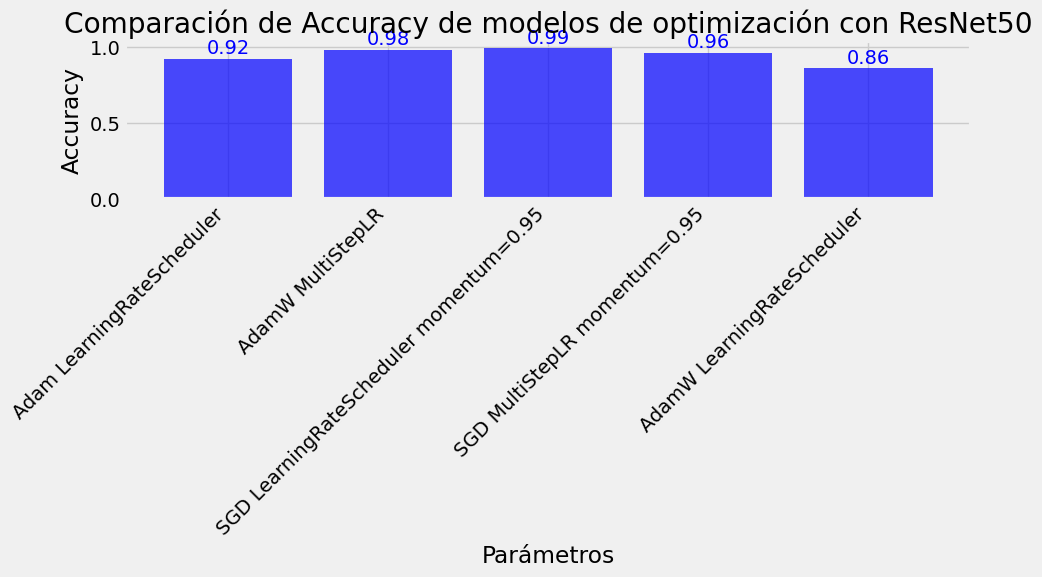

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Definir los datos
data = {
    "Parámetros": [
        "Adam LearningRateScheduler",
        "AdamW MultiStepLR",
        "SGD LearningRateScheduler momentum=0.95",
        "SGD MultiStepLR momentum=0.95",
        "AdamW LearningRateScheduler"
    ],
    "Accuracy": [0.92, 0.98, 0.99, 0.96, 0.86],
    "Loss": [0.26, 0.05, 0.05, 0.06, 0.44]
}

# Crear un DataFrame de pandas
df = pd.DataFrame(data)

# Crear un gráfico de barras para Accuracy
plt.figure(figsize=(10, 6))
plt.bar(df['Parámetros'], df['Accuracy'], color='b', alpha=0.7)
plt.xlabel('Parámetros')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy de modelos de optimización con ResNet50')
plt.xticks(rotation=45, ha='right')

# Añadir etiquetas de valor encima de las barras
for index, value in enumerate(df['Accuracy']):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom', color='b')

plt.tight_layout()
plt.show()


## Resultados Loss

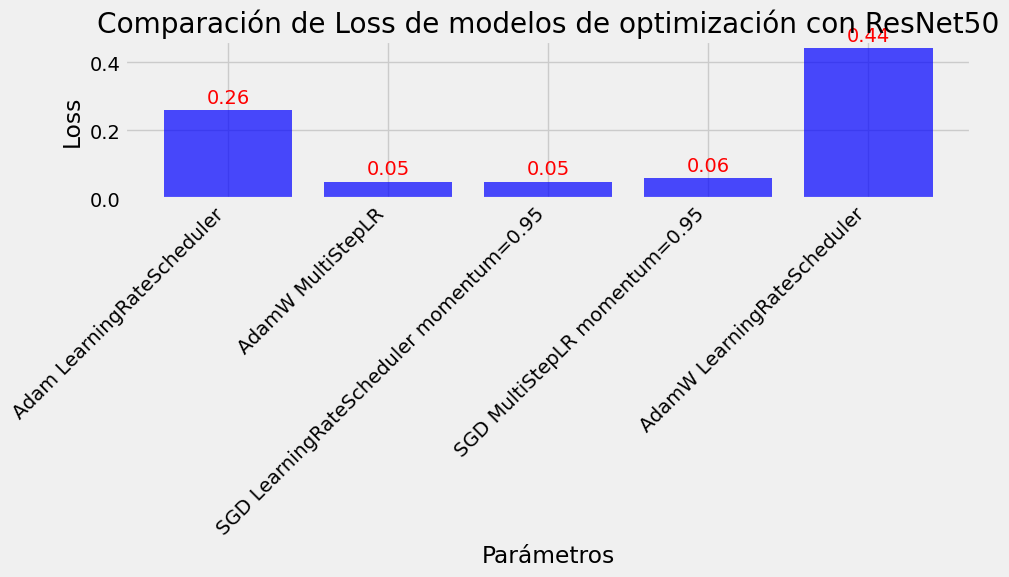

In [ ]:
# Crear un gráfico de barras para Loss
plt.figure(figsize=(10, 6))
plt.bar(df['Parámetros'], df['Loss'], color='b', alpha=0.7)
plt.xlabel('Parámetros')
plt.ylabel('Loss')
plt.title('Comparación de Loss de modelos de optimización con ResNet50')
plt.xticks(rotation=45, ha='right')

# Añadir etiquetas de valor encima de las barras
for index, value in enumerate(df['Loss']):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom', color='r')

plt.tight_layout()
plt.show()


## Comparación Modelo ResNet50 con y sin CLAHE

*  El ajuste del brillo en el subconjunto de datos de entrenamiento, que implicaba modificar la intensidad de brillo entre un 80% menos y un 120% más del valor original, parece haber sido efectivo para mejorar la capacidad de generalización del modelo. Este ajuste aumenta la variabilidad en los datos de entrenamiento, ayudando al modelo a aprender características más generales y a evitar el sobreajuste. La falta de CLAHE en el preprocesamiento no afectó negativamente a la capacidad del modelo para generalizar, dado que ResNet50 sin CLAHE logró una mayor precisión y menor pérdida.



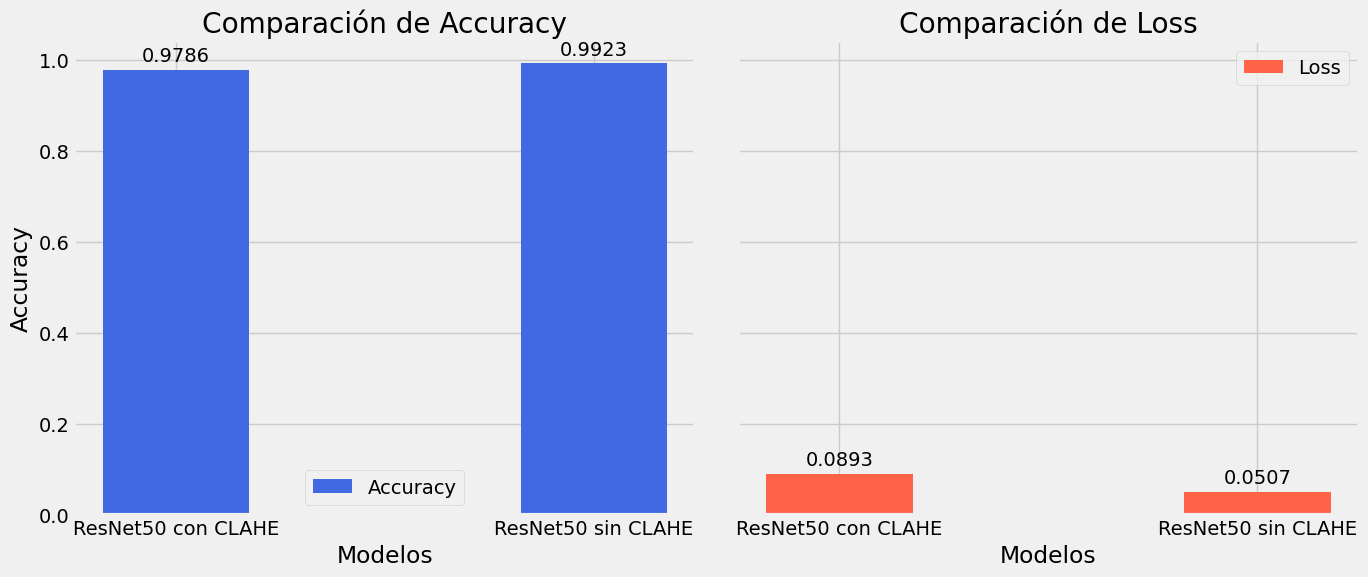

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
model_names = ['ResNet50 con CLAHE', 'ResNet50 sin CLAHE']
accuracy = [0.9786, 0.9923]
loss = [0.0893, 0.0507]

# Posiciones de las barras
x = np.arange(len(model_names))  # Las posiciones en el eje x para los modelos
width = 0.35  # Ancho de las barras

# Crear la figura y los ejes para las subgráficas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Crear las barras para Accuracy
bars_accuracy = ax1.bar(x, accuracy, width, color='royalblue', label='Accuracy')
ax1.set_xlabel('Modelos')
ax1.set_ylabel('Accuracy')
ax1.set_title('Comparación de Accuracy')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend()

# Añadir etiquetas de valor en las barras para Accuracy
for bar in bars_accuracy:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

# Crear las barras para Loss
bars_loss = ax2.bar(x, loss, width, color='tomato', label='Loss')
ax2.set_xlabel('Modelos')
ax2.set_title('Comparación de Loss')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names)
ax2.legend()

# Añadir etiquetas de valor en las barras para Loss
for bar in bars_loss:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
